# Прогнозирование музыкального жанра

**Описание полей данных**
- `instance_id` - уникальный идентификатор трека
- `track_name` - название трека
- `acousticness` - акустичность
- `danceability` - танцевальность
- `duration_ms` -продолжительность в милисекундах
- `energy` - энергичность
- `instrumentalness` - инструментальность
- `key` - базовый ключ (нота) произведения
- `liveness` - привлекательность
- `loudness` - громкость
- `mode` - указывает на модальность (мажорную или минорную) трека
- `speechiness` - выразительность
- `tempo` - темп
- `obtained_date` - дата загрузки в сервис
- `valence` - привлекательность произведения для пользователей сервиса
- `music_genre` - музыкальный жанр

## Данные

### Импорты

In [441]:
%pip install sweetviz
%pip install scikit-learn==1.1.3
%pip install catboost
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [442]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import *

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [443]:
train_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/kaggle_music_genre_train.csv')
test_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/kaggle_music_genre_test.csv')

submit_test = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/sample_submit.csv')

### Обзор данных

Напишем функцию для простого EDA

In [444]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('| Первые 10 строчек датасета |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('| Последние 10 строчек датасета |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Описательная статистика |')
    print('---------------------------')
    print(df.describe())
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('| Ковариационная матрица |')
    print('--------------------------')
    plt.show()

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64

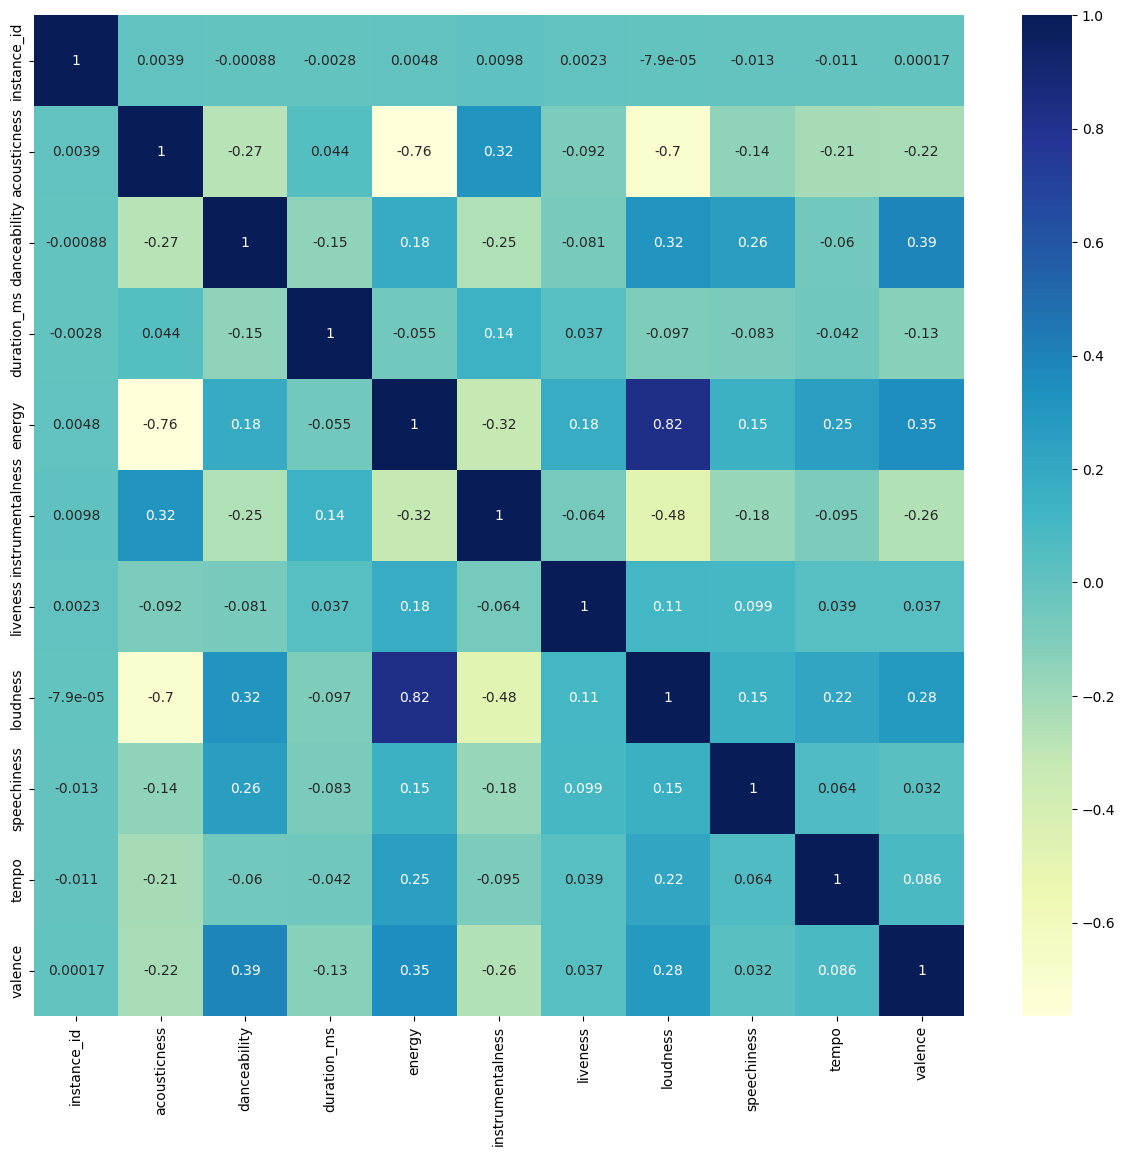

In [445]:
info_df(train_data)

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
d

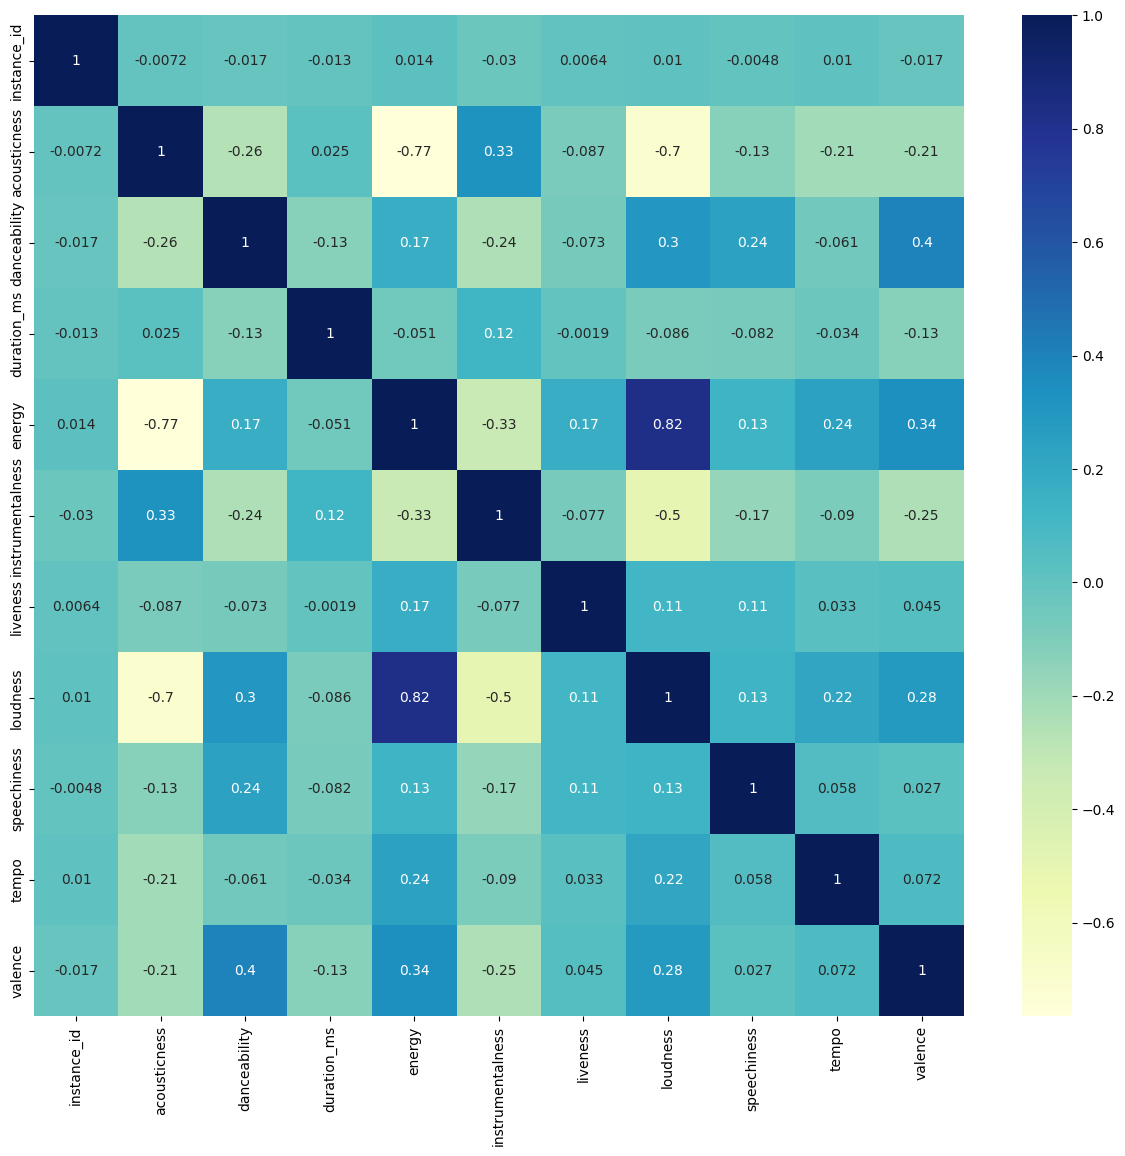

In [446]:
info_df(test_data)

Посмотрим на соотношение пропусков данных

In [447]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000


In [448]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.100000
liveness,0.000000
loudness,0.000000


### Константы

In [449]:
RANDOM_STATE = 1220

# Дополнительная информация из сторонних датасетов

In [450]:
train_data_2 = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/music_genre.csv')

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 

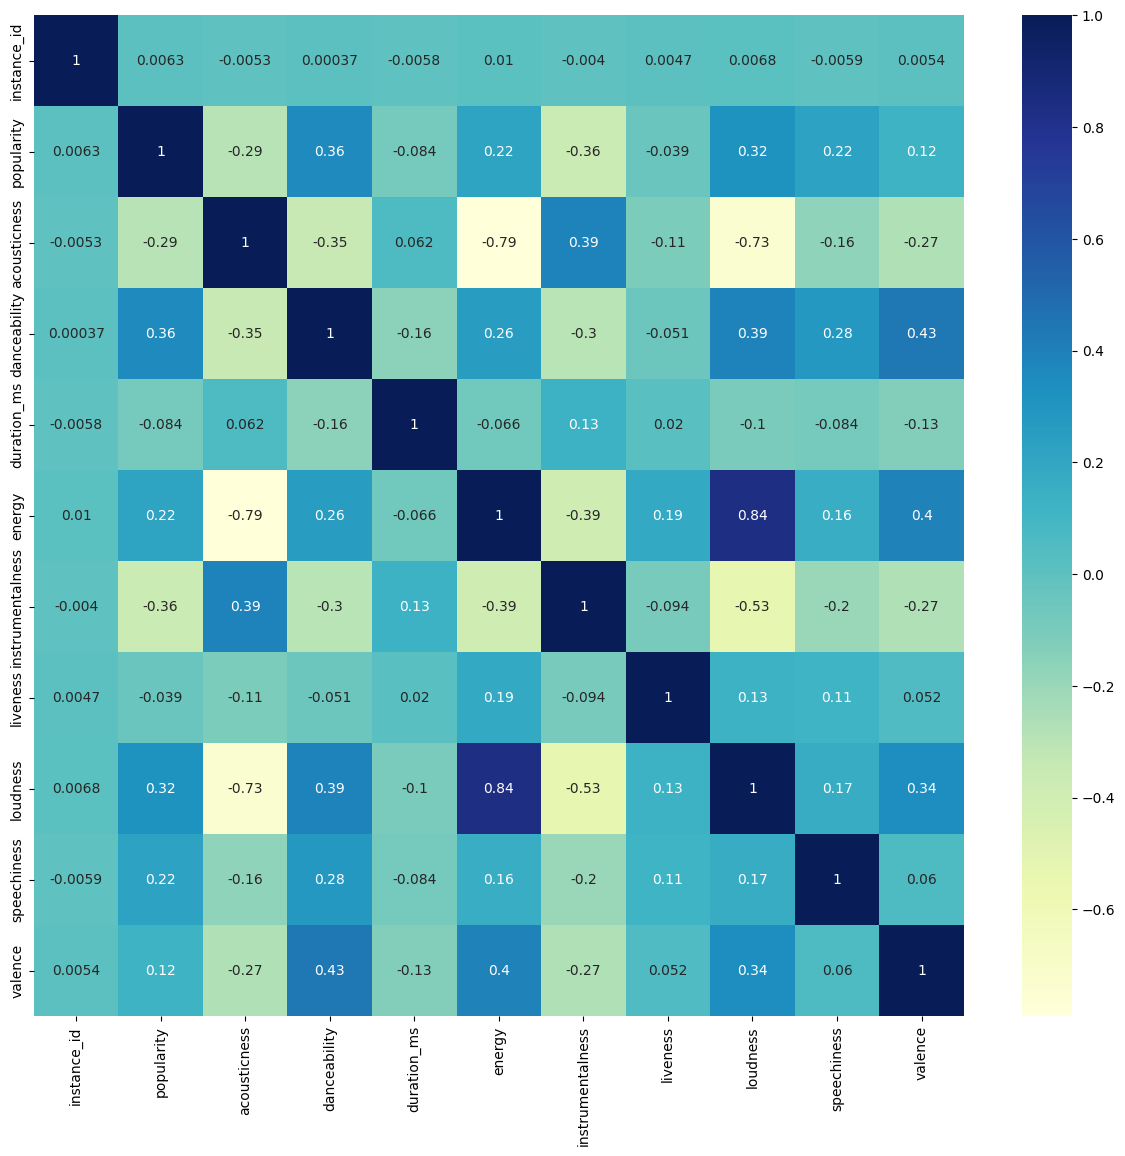

In [451]:
info_df(train_data_2)

Перобразуем названия треков в новом датасете в название жанра для слияния двух таблиц

In [452]:
train_data = train_data.drop(['instance_id', 'obtained_date', 'track_name'], axis=1)

In [453]:
train_data_2 = train_data_2.drop(['artist_name', 'instance_id', 'obtained_date', 'popularity', 'track_name'], axis=1)

In [454]:
train_data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,0.450,Country
1,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,0.539,Rock
2,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,0.344,Alternative
3,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,0.966,Hip-Hop
4,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,0.583,Alternative


In [455]:
train_data_2.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic


In [456]:
train_data = pd.concat([train_data, train_data_2])

In [457]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,1.100000
liveness,0.000000
loudness,0.000000
mode,0.700000
speechiness,0.000000


In [458]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70399 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70394 non-null  float64
 1   danceability      70394 non-null  float64
 2   duration_ms       70394 non-null  float64
 3   energy            70394 non-null  float64
 4   instrumentalness  70394 non-null  float64
 5   key               69659 non-null  object 
 6   liveness          70394 non-null  float64
 7   loudness          70394 non-null  float64
 8   mode              69888 non-null  object 
 9   speechiness       70394 non-null  float64
 10  tempo             69952 non-null  object 
 11  valence           70394 non-null  float64
 12  music_genre       70394 non-null  object 
dtypes: float64(9), object(4)
memory usage: 7.5+ MB


/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70399 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70394 non-null  float64
 1   danceability      70394 non-null  float64
 2   duration_ms       70394 non-null  float64
 3   energy            70394 non-null  float64
 4   instrumentalness  70394 non-null  float64
 5   key               69659 non-null  object 
 6   liveness          70394 non-null  float64
 7   loudness          70394 non-null  float64
 8   mode              69888 non-null  object 
 9   speechiness       70394 non-null  float64
 10  tempo             69952 non-null  object 
 11  valence           70394 non-null  float64
 12  music_genre       70394 non-null  object 
dtypes: float64(9), object(4)
memory usage: 7.5+ MB
------------------------------
| Первые 1

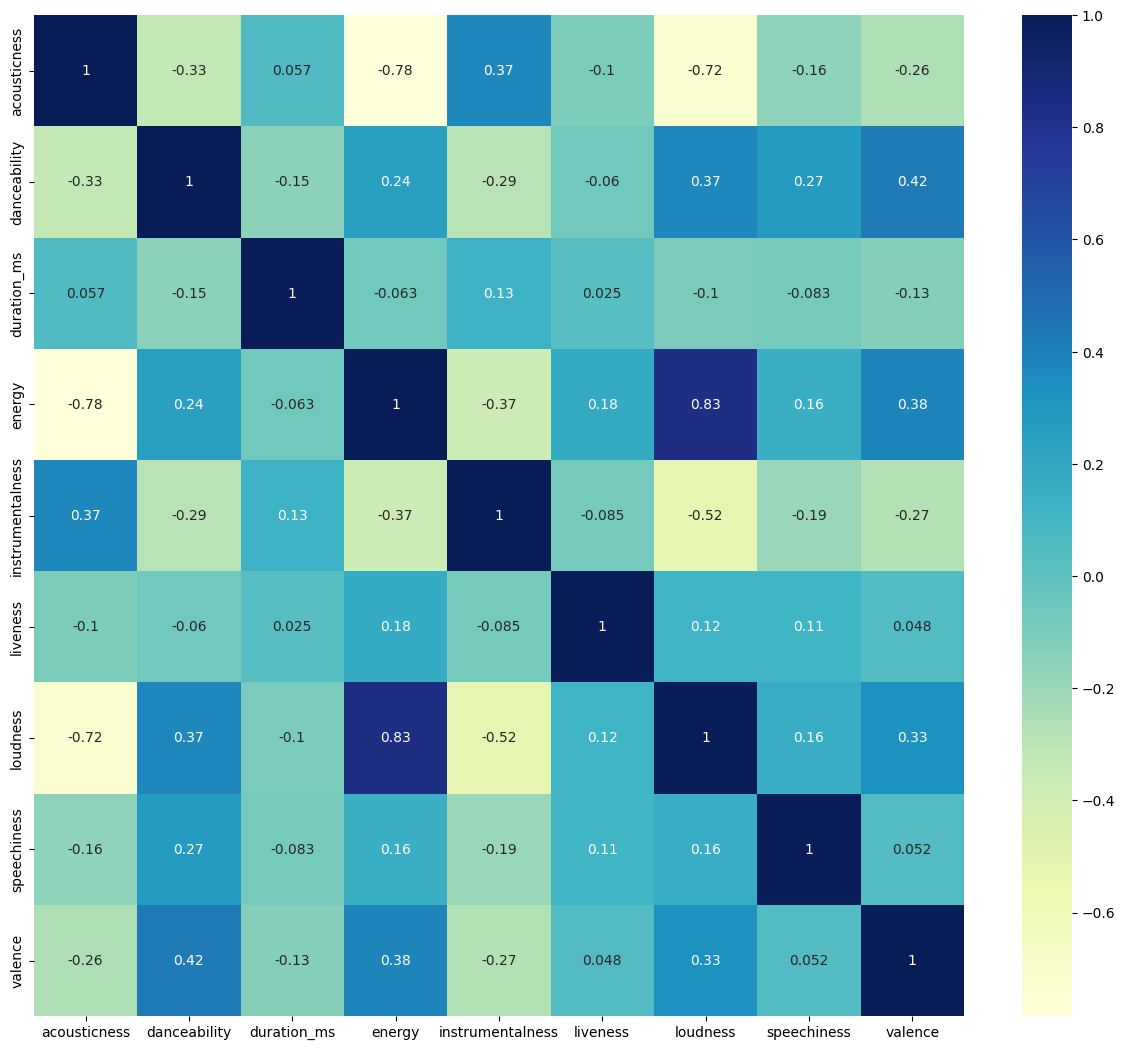

In [459]:
info_df(train_data)

## Предобработка и исследовательский анализ данных

## Пропуски в данных

**Popularity**

Пропуски заполним медианными значениями для каждого жанра

In [460]:
# for genre in train_data['music_genre'].unique():
#     train_data.loc[(train_data['music_genre'] == genre) & (train_data['popularity'].isna()),'popularity'] = \
#     train_data.loc[train_data['music_genre'] == genre, 'popularity'].median()

**Key**

In [461]:
train_data.loc[train_data['key'].isna(), 'key'] = 'N'
train_data.loc[train_data['mode'].isna(), 'mode'] = 'N'

test_data.loc[test_data['key'].isna(), 'key'] = 'N'
test_data.loc[test_data['mode'].isna(), 'mode'] = 'N'

In [462]:
mode_dict = {'Major' : 1, 'Minor' : 0, 'N': -1}
key_dict = {'N': -1,'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 12}

train_data['mode'].replace(mode_dict, inplace=True)
train_data['key'] = train_data['key'].replace(key_dict).astype(int)
test_data['mode'].replace(mode_dict, inplace=True)
test_data['key'] = test_data['key'].replace(key_dict).astype(int)

In [463]:
train_data['key'].unique()

array([ 3, 11,  5, 10,  1,  4, 12,  6,  7, -1,  9,  2])

**Tempo**

In [464]:
train_data.loc[train_data['tempo'].isna() == True]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
63,0.287000,0.476,212427.0,0.612,0.000252,11,0.0877,-7.010,1,0.0335,NaN,0.909,Rock
85,0.000059,0.489,269000.0,0.947,0.000000,2,0.1130,-3.925,0,0.0419,NaN,0.517,Anime
114,0.348000,0.698,362267.0,0.800,0.000087,12,0.4430,-3.091,0,0.0284,NaN,0.654,Blues
138,0.008340,0.776,191210.0,0.783,0.044900,1,0.0377,-3.595,1,0.0374,NaN,0.943,Electronic
145,0.001100,0.608,178440.0,0.801,0.000008,11,0.2230,-5.452,0,0.0376,NaN,0.544,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN


In [465]:
test_data.loc[test_data['tempo'].isna() == True]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
101,79753,She Walks In Beauty,0.981000,0.174,287360.0,0.0289,0.829000,9,0.0817,-25.038,1,0.0391,NaN,3-Apr,0.0315
131,27331,Tell Me Why,0.098400,0.611,142013.0,0.4490,0.000000,3,0.2260,-8.938,0,0.2940,NaN,4-Apr,0.2240
172,34855,Like You,0.383000,0.616,184033.0,0.4090,0.000000,2,0.1400,-8.427,1,0.2980,NaN,4-Apr,0.4530
212,43840,Matador (feat. Thompson Square),0.003600,0.528,241293.0,0.8250,0.000002,12,0.3690,-4.740,0,0.0602,NaN,4-Apr,0.4090
343,79286,New Fang,0.000010,0.276,228640.0,0.9620,0.000366,12,0.0327,-3.797,0,0.0629,NaN,4-Apr,0.7410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4918,50651,8 Bit Superhero,0.000346,0.377,296250.0,0.9200,0.903000,7,0.1950,-3.233,0,0.0529,NaN,4-Apr,0.1410
4923,89536,Whatcha Gonna Do With A Cowboy,0.342000,0.723,154000.0,0.8110,0.000000,11,0.0960,-4.147,1,0.1080,NaN,4-Apr,0.9210
4986,83279,First World Problemz / Nobody Carez,0.259000,0.582,350549.0,0.5020,0.000378,4,0.1600,-11.053,0,0.1020,NaN,4-Apr,0.5550
5076,54490,Deliver Me,0.000078,0.290,253839.0,0.8680,0.000005,2,0.4080,-4.392,1,0.0773,NaN,4-Apr,0.1930


In [466]:
train_data[train_data['tempo'] == '?']

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
5,0.00523,0.755,519468.0,0.731,0.854000,3,0.2160,-10.517,0,0.0412,?,0.6140,Electronic
32,0.02330,0.729,274286.0,0.869,0.585000,6,0.0944,-7.569,0,0.1290,?,0.1380,Electronic
35,0.10800,0.493,-1.0,0.682,0.000000,11,0.1960,-5.781,0,0.2870,?,0.2390,Electronic
36,0.04780,0.646,253333.0,0.649,0.002520,9,0.3530,-5.259,1,0.1170,?,0.7270,Electronic
39,0.20300,0.769,429941.0,0.551,0.882000,12,0.1090,-12.520,0,0.0408,?,0.0618,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,0.29600,0.379,292520.0,0.644,0.000000,12,0.3130,-7.933,0,0.1120,?,0.1440,Hip-Hop
49964,0.08470,0.929,215200.0,0.737,0.000000,10,0.8610,-6.424,1,0.1020,?,0.8860,Hip-Hop
49967,0.17900,0.860,233293.0,0.625,0.000136,3,0.3000,-6.922,1,0.1050,?,0.2210,Hip-Hop
49976,0.70000,0.462,225067.0,0.741,0.000000,12,0.3400,-8.008,0,0.1620,?,0.5890,Hip-Hop


In [467]:
test_data[test_data['tempo'] == '?']

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence


In [468]:
for genre in train_data['music_genre'].unique():
    train_data.loc[(train_data['music_genre'] == genre) 
                   & (train_data['tempo'] == '?') 
                   | (train_data['tempo'].isna() == True),
                   'tempo'] = \
    train_data.loc[(train_data['music_genre'] == genre)
                   & (train_data['tempo'] != '?'),
                     'tempo'].median()

In [469]:
test_data.loc[test_data['tempo'].isna() == True,'tempo'] = 0

In [470]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,0.000000
liveness,0.000000
loudness,0.000000
mode,0.000000
speechiness,0.000000


Проверим наличие явных дубликатов

In [471]:
train_data.duplicated().sum()

44

In [472]:
train_data = train_data.drop_duplicates().reset_index(drop=True)

In [473]:
train_data[train_data['music_genre'].isna()]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
30375,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,122.862,NaN,NaN


## Преобразование типов данных

In [474]:
train_data['tempo'] = train_data['tempo'].astype('float32')

#### Поиск аномальных значений

Взглянем еще раз на данные нашего тренировачного датасета

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70355 entries, 0 to 70354
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70354 non-null  float64
 1   danceability      70354 non-null  float64
 2   duration_ms       70354 non-null  float64
 3   energy            70354 non-null  float64
 4   instrumentalness  70354 non-null  float64
 5   key               70355 non-null  int64  
 6   liveness          70354 non-null  float64
 7   loudness          70354 non-null  float64
 8   mode              70355 non-null  int64  
 9   speechiness       70354 non-null  float64
 10  tempo             70355 non-null  float32
 11  valence           70354 non-null  float64
 12  music_genre       70354 non-null  object 
dtypes: float32(1), float64(9), int64(2), object(1)
memory usage: 6.7+ MB
-------------------

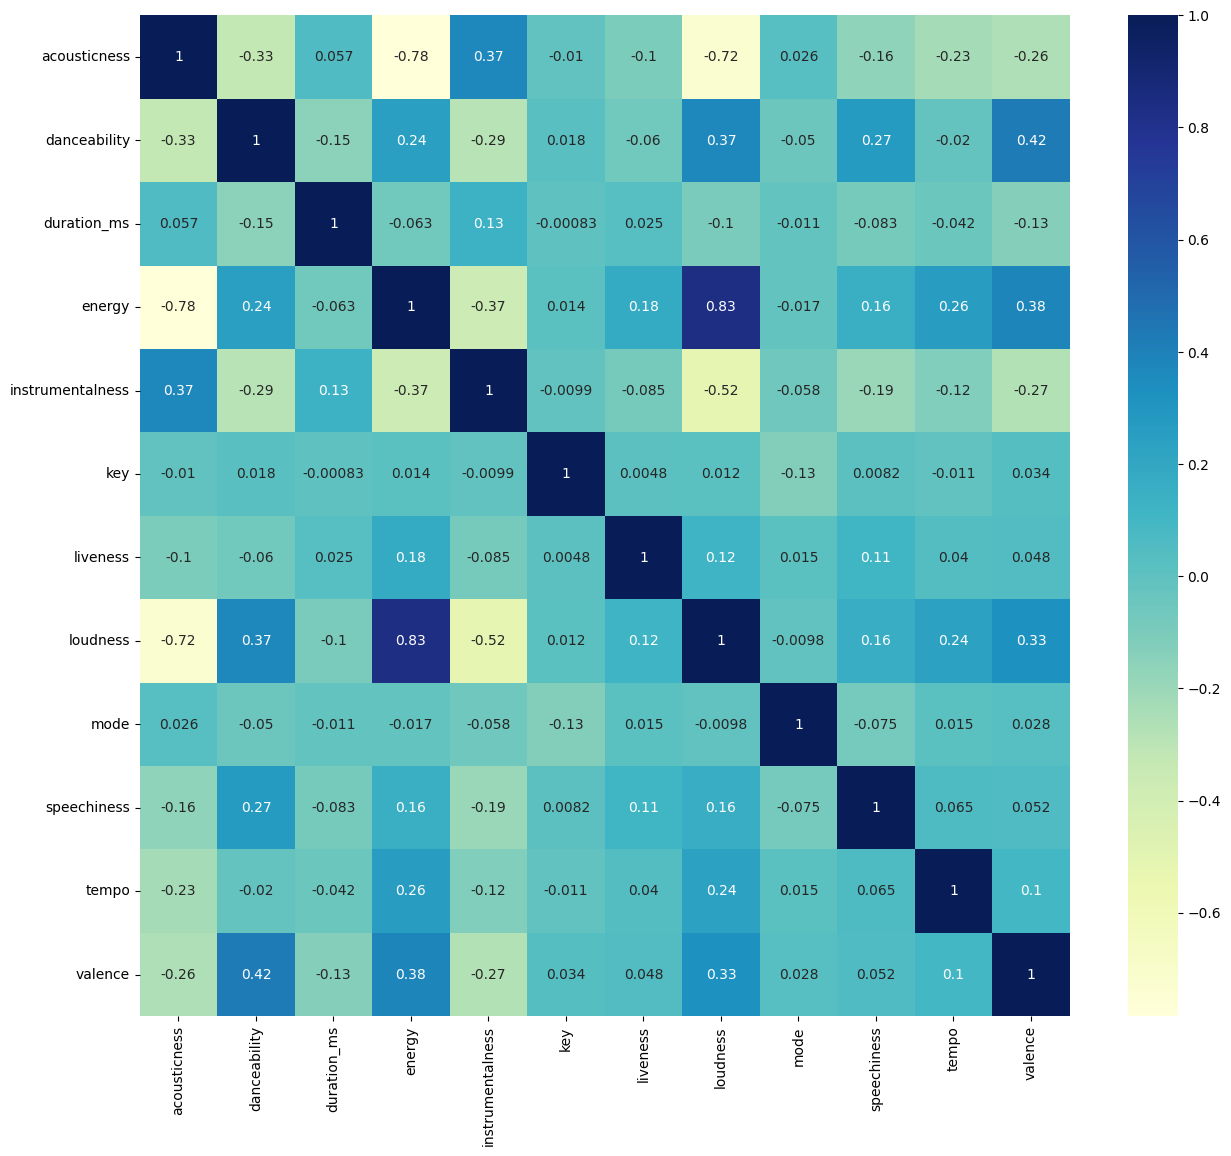

In [475]:
info_df(train_data)

In [476]:
train_data.duplicated().sum()

18748

In [477]:
train_data = train_data.drop_duplicates().reset_index(drop=True)

Обратим внимание на длительность некоторых треков в -1 миллисекунду. Вариантов несколько: можно удалить все треки которые имеют такое значение и потерять кусочек данных, можно заменить медианным значением всех треков, а можно оставить как есть и перед обучением модели (после масштабирования признаков) занизить это значение, дабы оно не влияло на обучение

**Длительность трека**

Оценим экстремумы треков в датасете

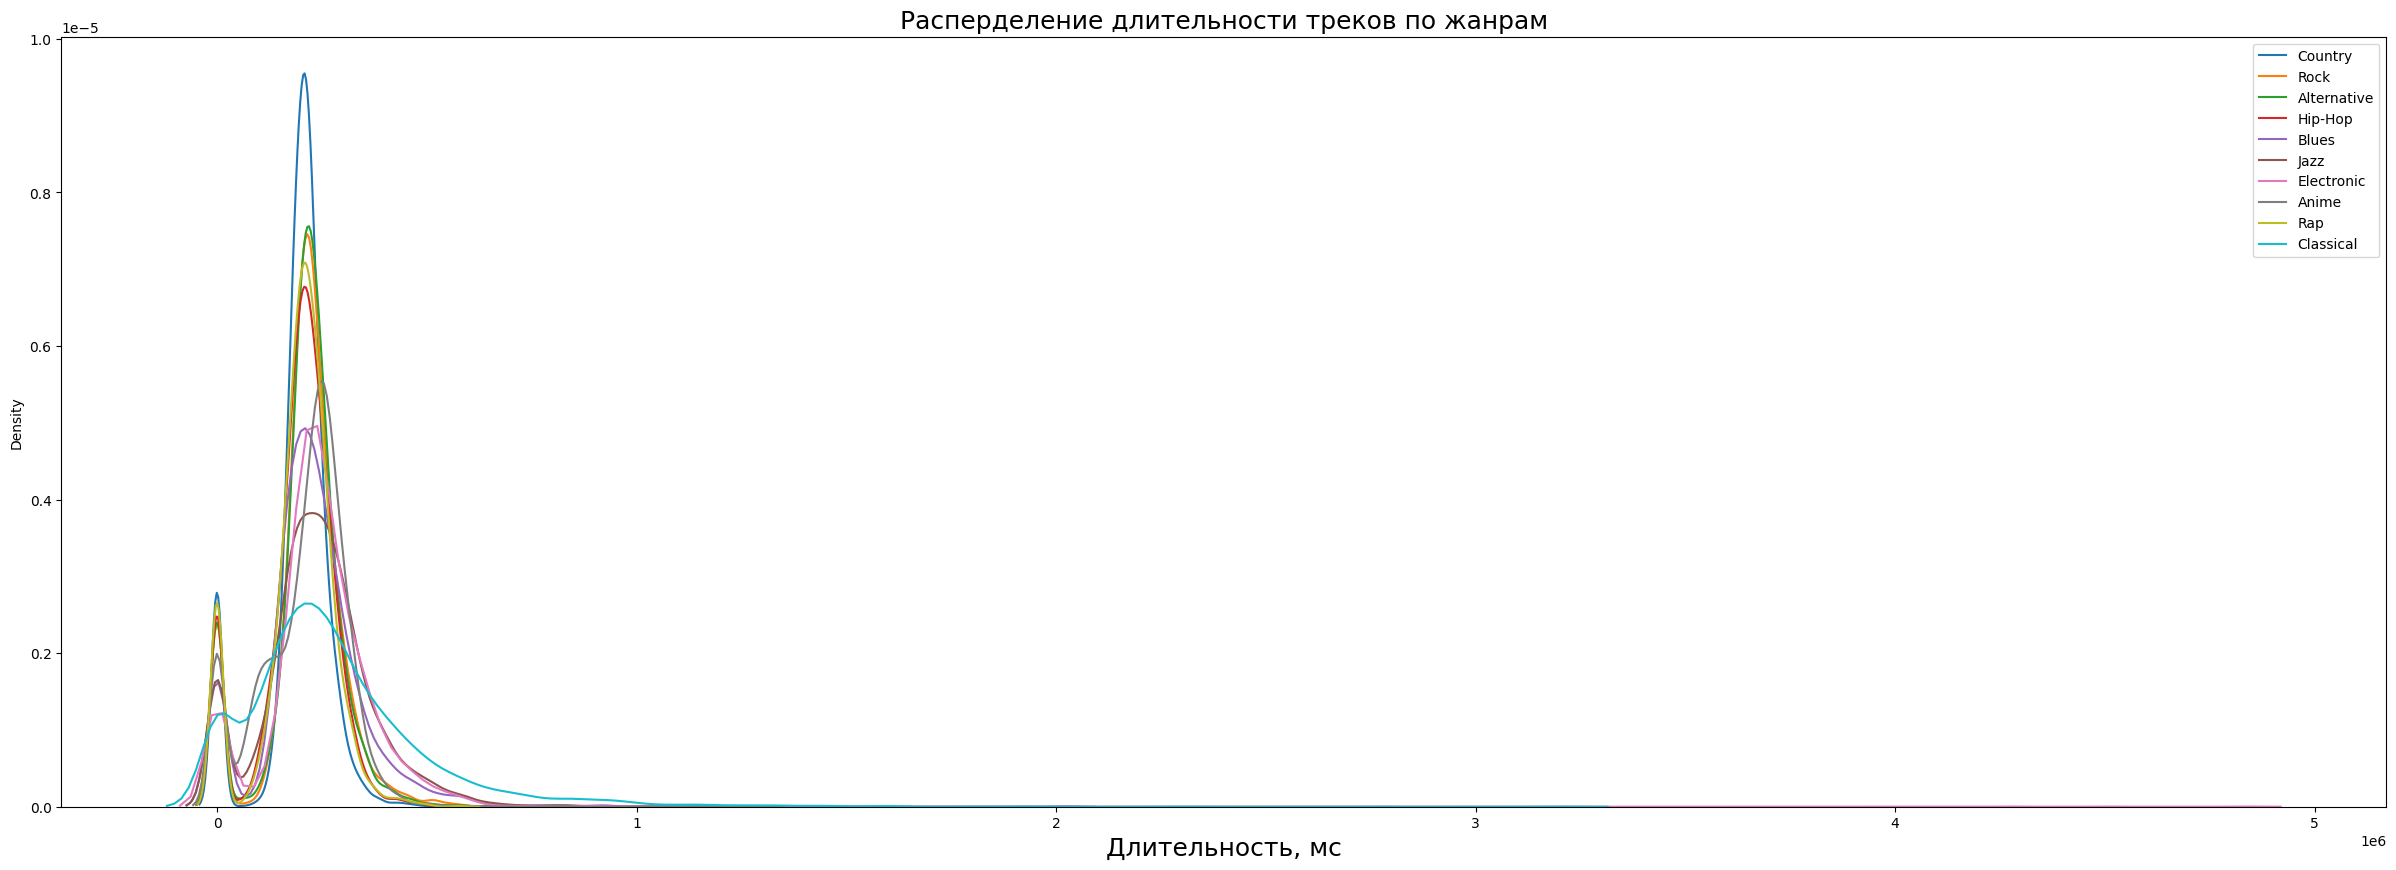

In [401]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[train_data['music_genre']==genre, 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Видно, что данные имеют аномальные значения. Особенно это видно на максимальной длительности трека. Возьмем ограничения в 2 стандартных отклонения

In [402]:
print((train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95]
               .groupby('music_genre')['track_name']
               .agg({'count'})))

print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95, 'track_name']
               .count()))

             count
music_genre       
Alternative    592
Anime         1030
Blues          581
Classical      997
Country        523
Electronic     579
Hip-Hop        677
Jazz           745
Rap            691
Rock           568
Всего треков: 6983


Наибольшее количество коротких треков относится к жанрам:
- `Anime`
- `Classical`
- `Rap`


In [403]:
print((train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2]
               .groupby('music_genre')['track_name']
               .agg('count')))
print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2, 'track_name']
               .count()))

music_genre
Alternative    1254
Anime          1776
Blues          1757
Classical      2354
Country         681
Electronic     2053
Hip-Hop        1066
Jazz           2100
Rap             976
Rock           1304
Name: track_name, dtype: int64
Всего треков: 15321


А наибольшее количество долгих треков относится к жанрам:
- `Electronic`
- `Blues`
- `Jazz`

Отберем только те треки длительность которых укладывается в заданый нами интервал и оценим расспределение длительности треков по жанрам

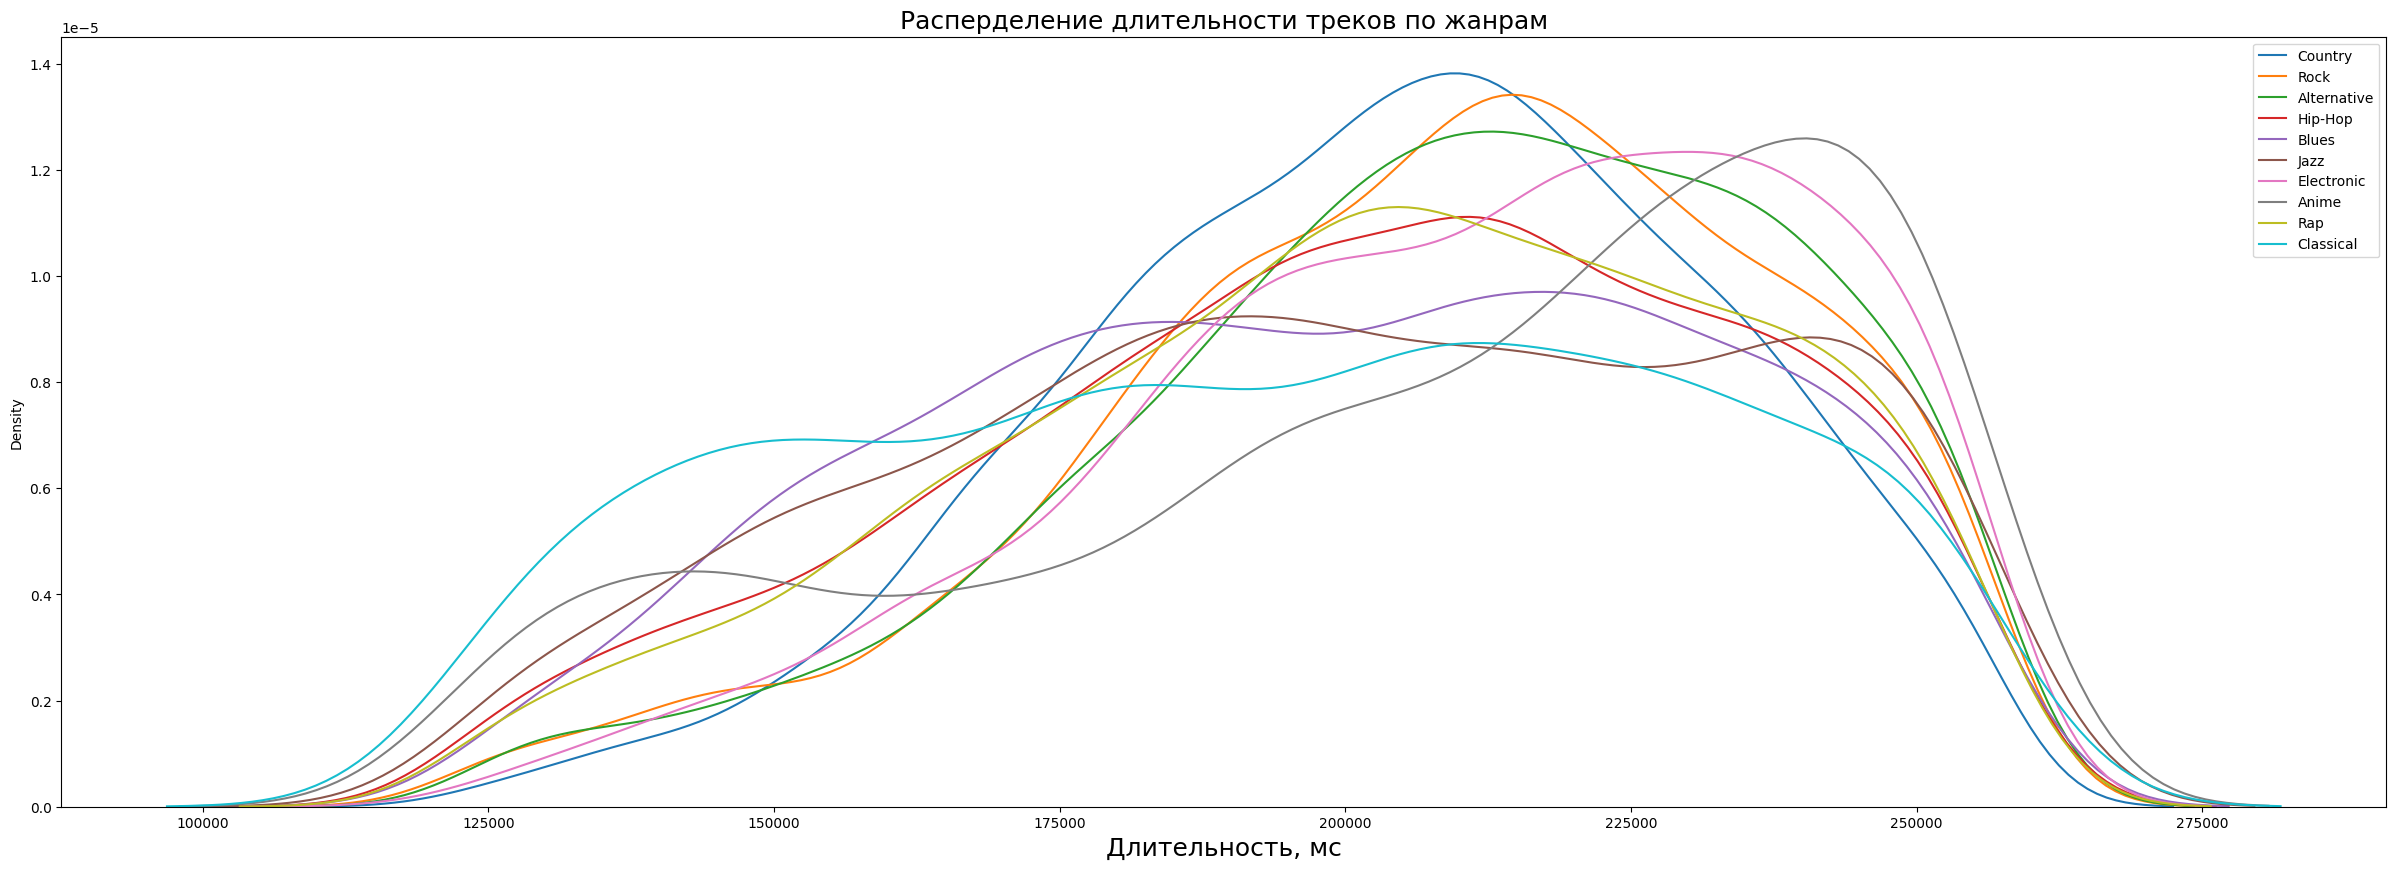

In [404]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre) & 
                                   ((train_data['duration_ms'] > train_data['duration_ms'].std() * 0.95) & 
                                    (train_data['duration_ms'] < train_data['duration_ms'].std() * 2)), 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Создадим новый признак `duration_class` который будет являтся идентификатором длительности трека (до OHE: short, median, long)

In [317]:
def sml_train_songs(row):
    if row < train_data['duration_ms'].std() * 0.95:
        return 'short'
    elif row > train_data['duration_ms'].std() * 3:
        return 'long'
    else:
        return 'median'

In [318]:
def sml_test_songs(row):
    if row < test_data['duration_ms'].std() * 0.95:
        return 'short'
    elif row > test_data['duration_ms'].std() * 3:
        return 'long'
    else:
        return 'median'

In [319]:
train_data['duration_class'] = train_data['duration_ms'].apply(sml_train_songs)

In [320]:
test_data['duration_class'] = test_data['duration_ms'].apply(sml_test_songs)

**Привлекательность**

Рассмотрим корреляцию между параметрами `liveness` - привлекательность и `valence` - привлекательность произведения для пользователей сервиса.


In [405]:
train_data.corr()

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/1402113604.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corr()


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
acousticness,1.000000,-0.345679,0.060435,-0.790664,0.385295,-0.010237,-0.108905,-0.729678,0.027577,-0.162677,-0.235186,-0.267932
danceability,-0.345679,1.000000,-0.154971,0.261488,-0.300000,0.018113,-0.052888,0.389423,-0.049204,0.278979,-0.005363,0.432672
duration_ms,0.060435,-0.154971,1.000000,-0.065319,0.129928,-0.001645,0.022260,-0.101567,-0.011605,-0.083754,-0.041754,-0.130974
energy,-0.790664,0.261488,-0.065319,1.000000,-0.387589,0.013700,0.186574,0.838068,-0.019506,0.157716,0.262914,0.394091
instrumentalness,0.385295,-0.300000,0.129928,-0.387589,1.000000,-0.008216,-0.092571,-0.527578,-0.054252,-0.198642,-0.129381,-0.272710
key,-0.010237,0.018113,-0.001645,0.013700,-0.008216,1.000000,0.004500,0.010337,-0.122943,0.007903,-0.010967,0.034768
liveness,-0.108905,-0.052888,0.022260,0.186574,-0.092571,0.004500,1.000000,0.125317,0.012869,0.114313,0.040320,0.051599
loudness,-0.729678,0.389423,-0.101567,0.838068,-0.527578,0.010337,0.125317,1.000000,-0.011141,0.165299,0.243395,0.338726
mode,0.027577,-0.049204,-0.011605,-0.019506,-0.054252,-0.122943,0.012869,-0.011141,1.000000,-0.071843,0.016029,0.020777
speechiness,-0.162677,0.278979,-0.083754,0.157716,-0.198642,0.007903,0.114313,0.165299,-0.071843,1.000000,0.065769,0.058818


Линейной зависимости от этих двух параметров не наблюдается. Оставим оба этих параметра и выберем наилучший путем рассчета значения Шэпли.

**Темп**

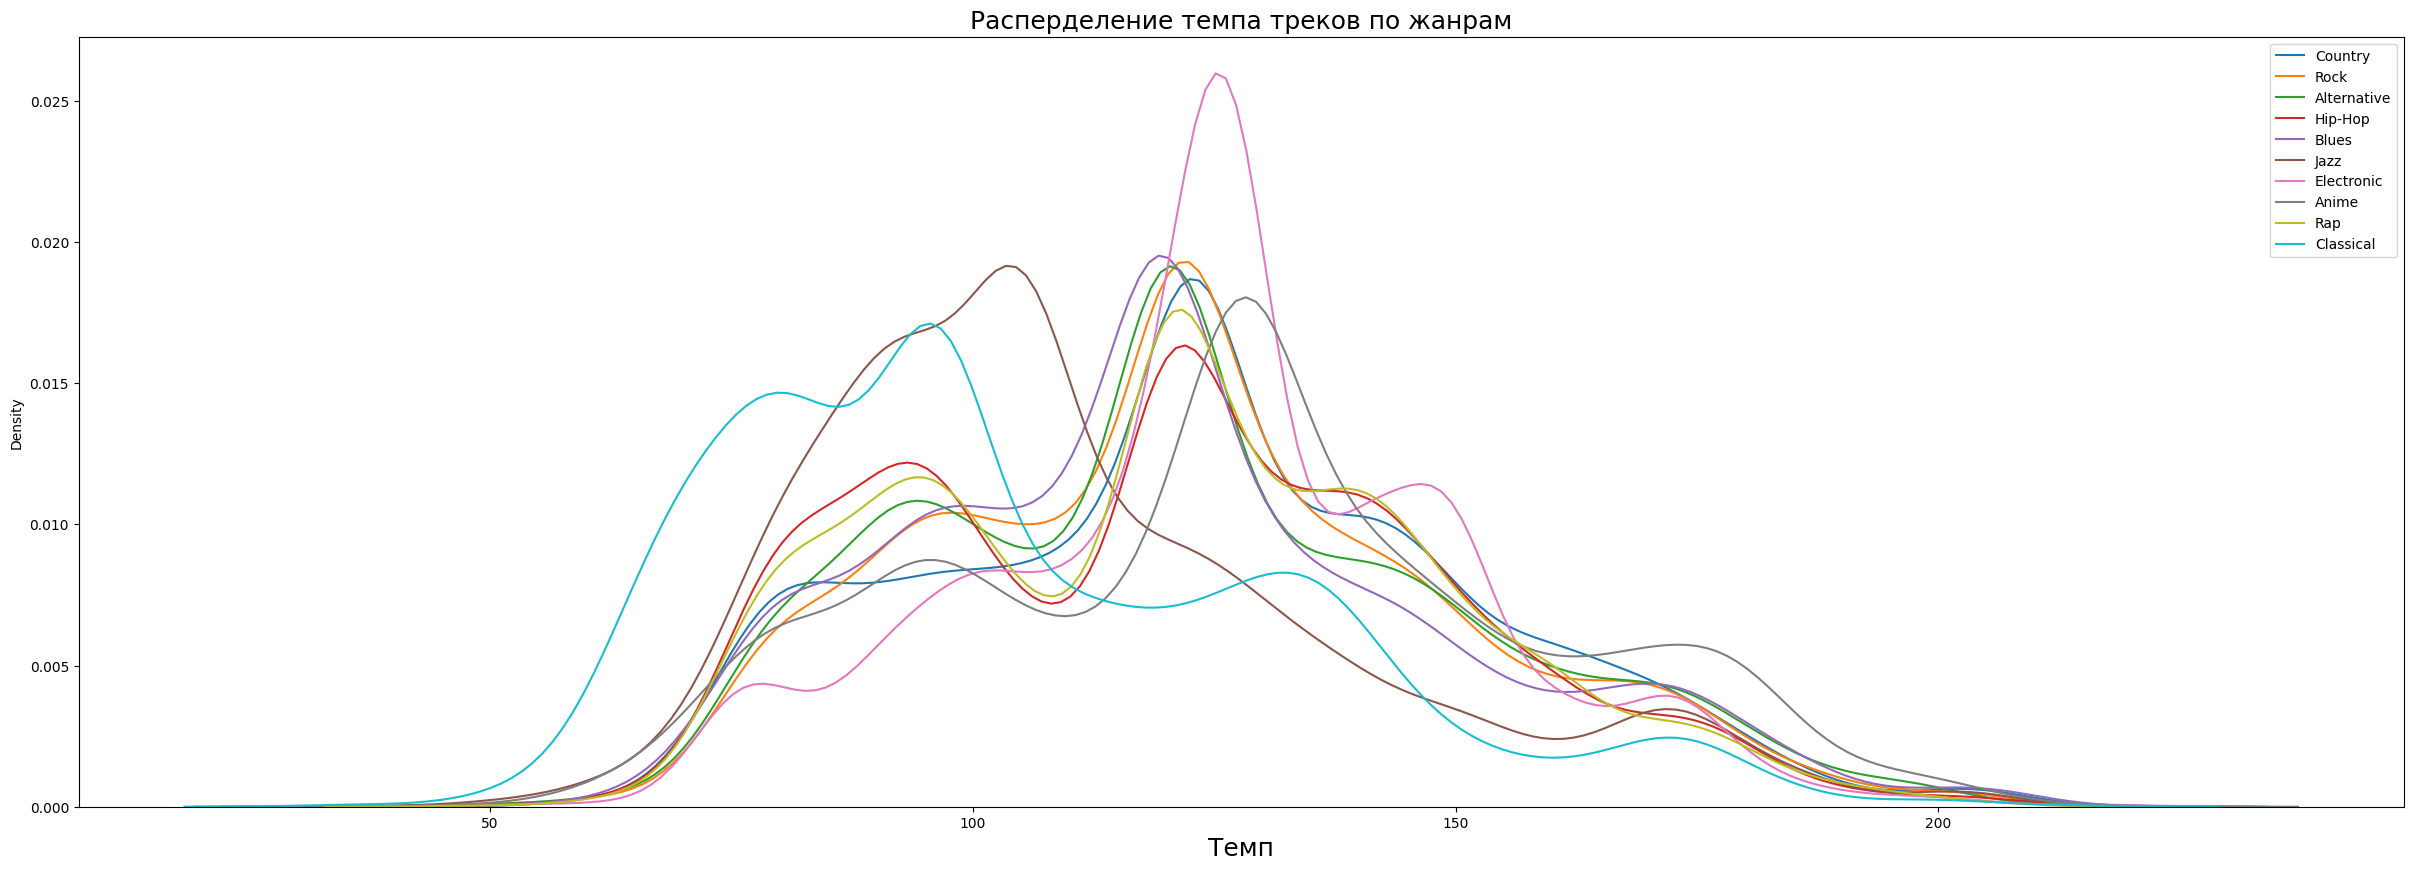

In [406]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre), 'tempo'], label=genre)

plt.title("Расперделение темпа треков по жанрам", fontsize = 18)

plt.xlabel("Темп", fontsize = 18)
plt.legend();

Можно отметить что для жанров Классической музыки, Джаза и Электронной  характерен высокий темп исполнения. Для заполнения пропусков в параметре Темп разделим медианное значение жанров Классика, Джаз, Электронная и оставшиеся жанры.

# Подготовка признаков

Исследуем четыре модели `DecisionTreeClassifier`, `RandomForestClassifier`, `LogisticRegression` и `CatBoost`. 

In [478]:
train_data['music_genre'].value_counts()/len(train_data)

Blues          0.101285
Rap            0.101052
Alternative    0.100820
Rock           0.100548
Electronic     0.100548
Country        0.100200
Anime          0.099773
Classical      0.098843
Hip-Hop        0.098494
Jazz           0.098417
Name: music_genre, dtype: float64

<Axes: xlabel='count', ylabel='music_genre'>

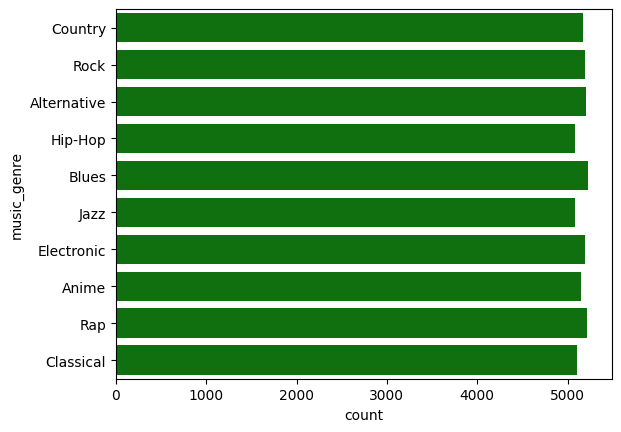

In [479]:
sb.countplot(y="music_genre", data=train_data, color='green')

In [480]:
# train_data = train_data.drop(['track_name', 'obtained_date', 'duration_class', 'liveness', 'tempo', 'loudness', 'duration_ms', 'key', 'mode'], axis=1)
# test_data = test_data.drop(['track_name', 'obtained_date', 'duration_class', 'liveness', 'tempo', 'loudness', 'duration_ms', 'key', 'mode'], axis = 1)
# train_data = train_data.drop(['track_name','duration_class', 'duration_ms','mode'], axis=1)
# test_data = test_data.drop(['track_name','duration_class', 'duration_ms','mode','obtained_date'], axis = 1)

In [481]:
train_data = train_data.dropna()

In [482]:
train_data.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64

In [483]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,0.000000
liveness,0.000000
loudness,0.000000
mode,0.000000
speechiness,0.000000


In [423]:
train_data_shuffle = train_data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [484]:
features = train_data.drop(['music_genre'], axis = 1)
target = train_data['music_genre']

features_test = test_data
target_test = submit_test['music_genre']

In [485]:
features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, train_size=0.8, random_state=RANDOM_STATE, stratify=target)

In [486]:
print(f"Train set has {features_train.shape[0]} records out of {len(train_data_shuffle)} which is {round(features_train.shape[0]/len(train_data_shuffle)*100)}%")
print(f"Valid set has {features_valid.shape[0]} records out of {len(train_data_shuffle)} which is {round(features_valid.shape[0]/len(train_data_shuffle)*100)}%")
print(f"Test set has {features_test.shape[0]} records out of {len(test_data)} which is {round(features_test.shape[0]/len(test_data)*100)}%")

Train set has 41284 records out of 51639 which is 80%
Valid set has 10322 records out of 51639 which is 20%
Test set has 5099 records out of 5099 which is 100%


In [487]:
target_train.value_counts().sort_index()

Alternative    4162
Anime          4119
Blues          4182
Classical      4081
Country        4137
Electronic     4151
Hip-Hop        4066
Jazz           4063
Rap            4172
Rock           4151
Name: music_genre, dtype: int64

In [541]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200)

In [542]:
model.fit(features_train, target_train)

LogisticRegression(max_iter=200, multi_class='multinomial')

In [543]:
y_pred = model.predict(features_valid)

In [544]:
from sklearn.metrics import classification_report
print(classification_report(target_valid, y_pred))

              precision    recall  f1-score   support

 Alternative       0.00      0.00      0.00      1041
       Anime       0.09      0.19      0.12      1030
       Blues       0.00      0.00      0.00      1045
   Classical       0.24      0.47      0.32      1020
     Country       0.10      0.21      0.14      1034
  Electronic       0.10      0.40      0.16      1038
     Hip-Hop       0.00      0.00      0.00      1017
        Jazz       0.00      0.00      0.00      1016
         Rap       0.00      0.00      0.00      1043
        Rock       0.00      0.00      0.00      1038

    accuracy                           0.13     10322
   macro avg       0.05      0.13      0.07     10322
weighted avg       0.05      0.13      0.07     10322



/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [493]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=30, random_state=RANDOM_STATE)
rfc.fit(features_train, target_train)

RandomForestClassifier(n_estimators=30, random_state=1220)

In [538]:
y_rfc = rfc.predict(features_test.drop(['instance_id','track_name', 'obtained_date'], axis=1))

In [539]:
print(classification_report(target_test, y_rfc))

              precision    recall  f1-score   support

 Alternative       0.11      0.13      0.12       502
       Anime       0.12      0.11      0.11       526
       Blues       0.10      0.14      0.12       503
   Classical       0.11      0.08      0.09       504
     Country       0.09      0.10      0.10       532
  Electronic       0.11      0.13      0.12       529
     Hip-Hop       0.08      0.05      0.06       517
        Jazz       0.08      0.06      0.07       498
         Rap       0.10      0.12      0.11       504
        Rock       0.10      0.11      0.10       484

    accuracy                           0.10      5099
   macro avg       0.10      0.10      0.10      5099
weighted avg       0.10      0.10      0.10      5099



In [545]:
from sklearn.feature_selection import RFE
selector = RFE(model, n_features_to_select=1)
selector.fit(features_train, target_train)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

RFE(estimator=LogisticRegression(max_iter=200, multi_class='multinomial'),
    n_features_to_select=1)

In [547]:
print(f"Model's Feature Importance")
for i in range(len(selector.ranking_)):
    print(f"#{i+1}: {features.columns[selector.ranking_[i]-1]} ")

Model's Feature Importance
#1: key 
#2: danceability 
#3: valence 
#4: energy 
#5: duration_ms 
#6: speechiness 
#7: liveness 
#8: mode 
#9: loudness 
#10: acousticness 
#11: tempo 
#12: instrumentalness 


In [559]:
def rebalance(data):
    from tqdm import tqdm
    # remove `a capella class`
    data = data[data['music_genre'] != 'A Capella']
    # set maximum occurence of data
    max_val = 5400 
    # create new dataframe 
    _data = pd.DataFrame(columns=data.columns)
    
    # iteratively add sample of songs based on genre 
    for genre in tqdm(data['music_genre'].unique()):
        _data = _data.append(data[data['music_genre'] == genre].sample(n=max_val, random_state=RANDOM_STATE, replace=True), ignore_index=True, sort=False)  
    return _data

In [560]:
balanced_df = rebalance(train_data)
balanced_df['duration_ms'] = balanced_df['duration_ms'].astype(int)
balanced_df['mode'].replace(mode_dict, inplace=True)
balanced_df['key'] = balanced_df['key'].replace(key_dict).astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(balanced_df.drop(columns='music_genre'),balanced_df['music_genre'], test_size=0.2, random_state=1)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/9451383.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _data = _data.append(data[data['music_genre'] == genre].sample(n=max_val, random_state=RANDOM_STATE, replace=True), ignore_index=True, sort=False)
100%|██████████| 10/10 [00:00<00:00, 307.66it/s]


In [561]:
lrm_rebalance = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200).fit(X_train, y_train)

In [562]:
print(classification_report(y_valid, lrm_rebalance.predict(X_valid)))

              precision    recall  f1-score   support

 Alternative       0.00      0.00      0.00      1080
       Anime       0.09      0.29      0.14      1031
       Blues       0.00      0.00      0.00      1055
   Classical       0.25      0.43      0.32      1132
     Country       0.08      0.11      0.10      1135
  Electronic       0.10      0.37      0.16      1073
     Hip-Hop       0.00      0.00      0.00      1059
        Jazz       0.00      0.00      0.00      1076
         Rap       0.00      0.00      0.00      1047
        Rock       0.00      0.00      0.00      1112

    accuracy                           0.12     10800
   macro avg       0.05      0.12      0.07     10800
weighted avg       0.05      0.12      0.07     10800



/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_3272/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      54000 non-null  float64
 1   danceability      54000 non-null  float64
 2   duration_ms       54000 non-null  int64  
 3   instrumentalness  54000 non-null  float64
 4   key               54000 non-null  int64  
 5   liveness          54000 non-null  float64
 6   mode              54000 non-null  int64  
 7   speechiness       54000 non-null  float64
 8   tempo             54000 non-null  float32
 9   valence           54000 non-null  float64
 10  music_genre       54000 non-null  object 
dtypes: float32(1), float64(6), int64(3), object(1)
memory usage: 4.3+ MB
------------------------------
| Первые 10 строчек датасета |
------------------------------
   acousticness  dan

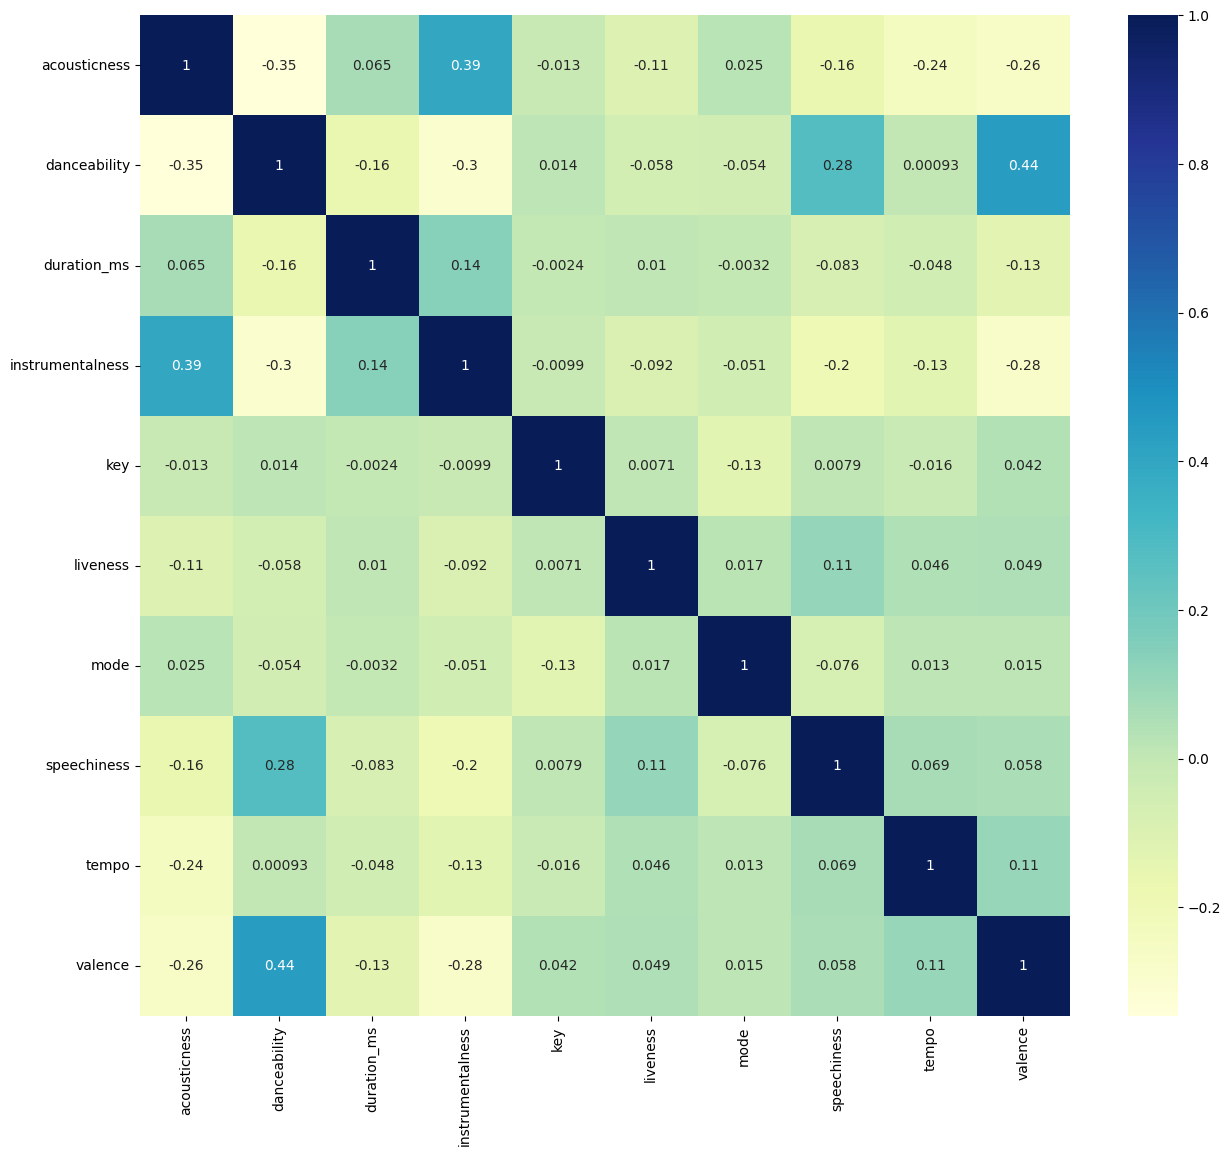

In [566]:
info_df(balanced_df.drop(columns=['energy', 'loudness']))

In [633]:
X_train, X_valid, y_train, y_valid = train_test_split(balanced_df.drop(columns=['music_genre','energy', 'loudness']),balanced_df['music_genre'], test_size=0.2, random_state=1)
lrm_cor = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200).fit(X_train, y_train)

In [634]:
print(classification_report(y_valid, lrm_cor.predict(X_valid)))

              precision    recall  f1-score   support

 Alternative       0.00      0.00      0.00      1080
       Anime       0.09      0.29      0.14      1031
       Blues       0.00      0.00      0.00      1055
   Classical       0.23      0.41      0.30      1132
     Country       0.08      0.11      0.10      1135
  Electronic       0.10      0.38      0.16      1073
     Hip-Hop       0.00      0.00      0.00      1059
        Jazz       0.00      0.00      0.00      1076
         Rap       0.00      0.00      0.00      1047
        Rock       0.00      0.00      0.00      1112

    accuracy                           0.12     10800
   macro avg       0.05      0.12      0.07     10800
weighted avg       0.05      0.12      0.07     10800



/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [659]:
X_train, X_valid, y_train, y_valid = train_test_split(balanced_df.drop(columns=['music_genre', 'loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms']),balanced_df['music_genre'], test_size=0.2, random_state=1)
lrm_uf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200).fit(X_train, y_train)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [663]:
model = CatBoostClassifier(loss_function='MultiClass',
                                      iterations=3000,
                                      depth=10,
                                      learning_rate=0.2,
                                      random_state=RANDOM_STATE,
                                      early_stopping_rounds = 200
                                      ).fit(X_train, 
                                        y_train,
                                        eval_set=(X_valid, y_valid))

0:	learn: 2.1326933	test: 2.1369648	best: 2.1369648 (0)	total: 37.5ms	remaining: 1m 52s
1:	learn: 2.0212900	test: 2.0325640	best: 2.0325640 (1)	total: 72ms	remaining: 1m 47s
2:	learn: 1.9518580	test: 1.9690357	best: 1.9690357 (2)	total: 106ms	remaining: 1m 45s
3:	learn: 1.8920916	test: 1.9132220	best: 1.9132220 (3)	total: 140ms	remaining: 1m 44s
4:	learn: 1.8527622	test: 1.8798375	best: 1.8798375 (4)	total: 176ms	remaining: 1m 45s
5:	learn: 1.8219896	test: 1.8543313	best: 1.8543313 (5)	total: 210ms	remaining: 1m 44s
6:	learn: 1.7970754	test: 1.8342834	best: 1.8342834 (6)	total: 246ms	remaining: 1m 45s
7:	learn: 1.7694064	test: 1.8128943	best: 1.8128943 (7)	total: 281ms	remaining: 1m 45s
8:	learn: 1.7516160	test: 1.7989166	best: 1.7989166 (8)	total: 319ms	remaining: 1m 46s
9:	learn: 1.7371030	test: 1.7872789	best: 1.7872789 (9)	total: 354ms	remaining: 1m 45s
10:	learn: 1.7201231	test: 1.7734223	best: 1.7734223 (10)	total: 390ms	remaining: 1m 45s
11:	learn: 1.7084102	test: 1.7626986	best

In [664]:
print(classification_report(y_valid, model.predict(X_valid)))

              precision    recall  f1-score   support

 Alternative       0.62      0.61      0.62      1080
       Anime       0.73      0.65      0.68      1031
       Blues       0.68      0.71      0.70      1055
   Classical       0.79      0.83      0.81      1132
     Country       0.68      0.75      0.71      1135
  Electronic       0.73      0.72      0.72      1073
     Hip-Hop       0.64      0.67      0.65      1059
        Jazz       0.73      0.69      0.71      1076
         Rap       0.61      0.62      0.61      1047
        Rock       0.63      0.59      0.61      1112

    accuracy                           0.68     10800
   macro avg       0.68      0.68      0.68     10800
weighted avg       0.68      0.68      0.68     10800



In [670]:
pred_cat = model.predict_proba(f_t)
pred_cat[0]

array([7.86705019e-01, 6.33999763e-05, 2.27463138e-05, 1.53936470e-04,
       2.55091522e-04, 6.95983755e-05, 9.30028007e-02, 3.07981412e-03,
       1.16631089e-01, 1.65043534e-05])

In [666]:
pred_cat[0].argmax()

0

In [679]:
model.classes_[pred_cat[0].argmax()]

'Alternative'

In [678]:
submission = pd.DataFrame({
    'instance_id': submit_test['instance_id'],
    'music_genre': mdfd_predf
})
submission.to_csv('submission.csv', index=False)
submission

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Anime
...,...,...
5094,50532,Alternative
5095,26255,Blues
5096,67924,Electronic
5097,79778,Country


In [637]:
print(classification_report(y_valid, lrm_uf.predict(X_valid)))

              precision    recall  f1-score   support

 Alternative       0.14      0.10      0.12      1080
       Anime       0.11      0.03      0.05      1031
       Blues       0.21      0.13      0.16      1055
   Classical       0.42      0.60      0.50      1132
     Country       0.21      0.74      0.33      1135
  Electronic       0.31      0.19      0.23      1073
     Hip-Hop       0.37      0.54      0.44      1059
        Jazz       0.26      0.07      0.11      1076
         Rap       0.14      0.14      0.14      1047
        Rock       0.30      0.00      0.01      1112

    accuracy                           0.26     10800
   macro avg       0.25      0.25      0.21     10800
weighted avg       0.25      0.26      0.21     10800



In [638]:
rfc = RandomForestClassifier(n_estimators=30, random_state=RANDOM_STATE)
print(classification_report(y_valid, rfc.fit(X_train, y_train).predict(X_valid)))

              precision    recall  f1-score   support

 Alternative       0.62      0.63      0.62      1080
       Anime       0.71      0.66      0.69      1031
       Blues       0.70      0.69      0.70      1055
   Classical       0.80      0.83      0.82      1132
     Country       0.70      0.76      0.73      1135
  Electronic       0.71      0.74      0.72      1073
     Hip-Hop       0.65      0.70      0.67      1059
        Jazz       0.75      0.70      0.72      1076
         Rap       0.62      0.61      0.61      1047
        Rock       0.67      0.61      0.63      1112

    accuracy                           0.69     10800
   macro avg       0.69      0.69      0.69     10800
weighted avg       0.69      0.69      0.69     10800



In [639]:
print(classification_report(y_valid, rfc.fit(X_train, y_train).predict(X_valid)))

              precision    recall  f1-score   support

 Alternative       0.62      0.63      0.62      1080
       Anime       0.71      0.66      0.69      1031
       Blues       0.70      0.69      0.70      1055
   Classical       0.80      0.83      0.82      1132
     Country       0.70      0.76      0.73      1135
  Electronic       0.71      0.74      0.72      1073
     Hip-Hop       0.65      0.70      0.67      1059
        Jazz       0.75      0.70      0.72      1076
         Rap       0.62      0.61      0.61      1047
        Rock       0.67      0.61      0.63      1112

    accuracy                           0.69     10800
   macro avg       0.69      0.69      0.69     10800
weighted avg       0.69      0.69      0.69     10800



In [640]:
f_t = features_test.drop(columns=['instance_id','track_name', 'obtained_date',
                                'loudness', 'danceability', 'acousticness', 
                                'valence', 'energy', 'duration_ms'])

In [641]:
preds = lrm_uf.predict_proba(f_t)
preds[0]

array([0.10626552, 0.05813384, 0.08898789, 0.03223892, 0.03952496,
       0.05902352, 0.24971083, 0.08393097, 0.2160571 , 0.06612644])

In [642]:
predsf = rfc.predict_proba(f_t)
predsf[0]

array([0.93333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02      , 0.        , 0.04666667, 0.        ])

In [643]:
preds[0].argmax()

6

In [644]:
predsf[0].argmax()

0

In [592]:
lrm_uf.classes_[preds[0].argmax()]

'Hip-Hop'

In [645]:
rfc.classes_[predsf[0].argmax()]

'Alternative'

In [646]:
print(f"""Predicted Class\t: {lrm_uf.classes_[preds[0].argmax()]}
Ground Truth\t: {target_test.values[0]}
Correctness\t: {lrm_uf.classes_[preds[0].argmax()] == target_test.values[0]}
""")

Predicted Class	: Hip-Hop
Ground Truth	: Hip-Hop
Correctness	: True



In [647]:
print(f"""Predicted Class\t: {rfc.classes_[predsf[0].argmax()]}
Ground Truth\t: {target_test.values[0]}
Correctness\t: {rfc.classes_[predsf[0].argmax()] == target_test.values[0]}
""")

Predicted Class	: Alternative
Ground Truth	: Hip-Hop
Correctness	: False



In [648]:
preds[0].argsort()[::-1][:5]

array([6, 8, 0, 2, 7])

In [649]:
predsf[0].argsort()[::-1][:5]

array([0, 8, 6, 9, 7])

In [651]:
lrm_uf.classes_[preds[0].argsort()[::-1][:5]]

array(['Hip-Hop', 'Rap', 'Alternative', 'Blues', 'Jazz'], dtype=object)

In [650]:
rfc.classes_[predsf[0].argsort()[::-1][:5]]

array(['Alternative', 'Rap', 'Hip-Hop', 'Rock', 'Jazz'], dtype=object)

In [652]:
print(f"""Predicted Class\t: {rfc.classes_[predsf[0].argsort()[::-1][:5]]}
Ground Truth\t: {target_test.values[0]}
Correctness\t: {target_test.values[0] in rfc.classes_[predsf[0].argsort()[::-1][:5]] }
""")

Predicted Class	: ['Alternative' 'Rap' 'Hip-Hop' 'Rock' 'Jazz']
Ground Truth	: Hip-Hop
Correctness	: True



In [621]:
preds_proba = lrm_uf.predict_proba(f_t)

In [653]:
preds_probaf = rfc.predict_proba(f_t)

In [676]:
def top5score(preds, ground_truth, model):
    if not len(preds) == len(ground_truth):
        raise exception('Shape Mismatch')
    
    mdfd_pred = []
    for i in range(len(preds)):
        preds_classes = model.classes_[preds[i].argsort()[::-1]]
        if ground_truth[i] in preds_classes :
            mdfd_pred.append(ground_truth[i])
        else:
            mdfd_pred.append(preds_classes[0])
    return mdfd_pred

In [655]:
preds_proba[0]

array([0.10626552, 0.05813384, 0.08898789, 0.03223892, 0.03952496,
       0.05902352, 0.24971083, 0.08393097, 0.2160571 , 0.06612644])

In [656]:
preds_probaf[0]

array([0.93333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02      , 0.        , 0.04666667, 0.        ])

In [629]:
mdfd_pred = top5score(preds_proba, target_test.values, lrm_uf)

In [657]:
mdfd_predf = top5score(preds_probaf, target_test.values, rfc)

In [630]:
print(classification_report(target_test,mdfd_pred ))

              precision    recall  f1-score   support

 Alternative       0.86      1.00      0.93       502
       Anime       0.96      0.98      0.97       526
       Blues       0.87      1.00      0.93       503
   Classical       0.47      0.26      0.34       504
     Country       0.51      0.71      0.59       532
  Electronic       0.86      0.74      0.80       529
     Hip-Hop       0.75      0.80      0.78       517
        Jazz       0.89      0.61      0.73       498
         Rap       0.79      0.86      0.83       504
        Rock       1.00      0.99      0.99       484

    accuracy                           0.80      5099
   macro avg       0.80      0.80      0.79      5099
weighted avg       0.79      0.80      0.79      5099



In [658]:
print(classification_report(target_test,mdfd_predf))

              precision    recall  f1-score   support

 Alternative       0.51      0.48      0.49       502
       Anime       0.53      0.44      0.48       526
       Blues       0.43      0.48      0.46       503
   Classical       0.46      0.33      0.38       504
     Country       0.40      0.38      0.39       532
  Electronic       0.41      0.42      0.41       529
     Hip-Hop       0.50      0.41      0.45       517
        Jazz       0.59      0.64      0.61       498
         Rap       0.53      0.60      0.56       504
        Rock       0.58      0.82      0.68       484

    accuracy                           0.50      5099
   macro avg       0.49      0.50      0.49      5099
weighted avg       0.49      0.50      0.49      5099



In [631]:
submission = pd.DataFrame({
    'instance_id': submit_test['instance_id'],
    'music_genre': mdfd_pred
})
submission.to_csv('submission.csv', index=False)
submission

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Hip-Hop
...,...,...
5094,50532,Alternative
5095,26255,Blues
5096,67924,Electronic
5097,79778,Electronic


In [331]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['key']


['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [332]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train[ohe_features])

features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

features_train = features_train.drop(ohe_features, axis=1)

In [333]:
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

In [334]:
features_valid

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_A#,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_N
46585,0.988000,0.220,0.0143,0.148000,0.1210,-24.289,0.0465,88.578003,0.1470,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22770,0.443000,0.214,0.5140,0.000007,0.1130,-6.570,0.0399,74.997002,0.1990,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22655,0.000117,0.575,0.9520,0.161000,0.0705,-2.919,0.0525,150.014008,0.1060,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
33689,0.950000,0.367,0.1780,0.423000,0.1230,-17.777,0.0422,96.570999,0.0995,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49236,0.000780,0.496,0.8980,0.000000,0.1910,-5.663,0.0491,195.867004,0.4400,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,0.005070,0.866,0.7230,0.000004,0.3170,-6.233,0.1890,120.605003,0.8280,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2156,0.993000,0.322,0.0864,0.724000,0.1150,-20.416,0.0346,58.258999,0.0759,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46342,0.006220,0.632,0.8940,0.000000,0.3280,-5.211,0.0317,102.039001,0.7180,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11453,0.046900,0.522,0.5420,0.000000,0.4160,-9.570,0.1850,155.059998,0.1490,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [335]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

In [336]:
scaler = StandardScaler()
features_train[num_features] = scaler.fit_transform(features_train[num_features])

scaler.fit(pd.DataFrame(features_train[num_features]))

StandardScaler()

In [337]:
features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [338]:
features_train

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_A#,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_N
3723,-0.835380,-0.624516,0.846495,-0.556859,-0.303701,0.783139,-0.565379,-0.700191,0.394407,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28665,-0.889241,0.267690,0.070727,-0.556865,-0.229935,0.253999,-0.366100,0.688867,0.082398,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34107,0.783955,0.593149,0.070727,2.309650,-0.500410,0.387993,-0.571298,0.277776,0.900916,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
24926,-0.771393,-0.428119,1.433050,-0.556856,0.753611,1.093948,0.288956,-1.022167,0.528125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3548,-0.363698,0.082515,0.460503,-0.556865,0.587637,0.424463,-0.633449,0.833984,0.540281,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18330,1.790720,-1.168818,-2.167646,-0.413078,-0.531146,-1.701540,-0.471658,-2.117532,-0.902255,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27904,-0.815127,-0.276612,0.486992,-0.556865,0.710580,0.748948,-0.459820,1.648873,-0.760433,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50657,-0.803680,-0.854582,0.702694,1.071906,-0.395908,0.585648,-0.571298,0.115589,1.233185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3857,1.811266,0.503367,-0.636925,2.208044,-0.613518,-0.664426,-0.525917,0.654454,0.252585,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [339]:
oversample = SMOTE(random_state=RANDOM_STATE, k_neighbors=10)
features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)

In [340]:
features_train_up

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_A#,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_N
0,-0.835380,-0.624516,0.846495,-0.556859,-0.303701,0.783139,-0.565379,-0.700191,0.394407,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,-0.889241,0.267690,0.070727,-0.556865,-0.229935,0.253999,-0.366100,0.688867,0.082398,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0
2,0.783955,0.593149,0.070727,2.309650,-0.500410,0.387993,-0.571298,0.277776,0.900916,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0
3,-0.771393,-0.428119,1.433050,-0.556856,0.753611,1.093948,0.288956,-1.022167,0.528125,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,-0.363698,0.082515,0.460503,-0.556865,0.587637,0.424463,-0.633449,0.833984,0.540281,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41835,-0.855991,0.082082,0.894892,-0.551645,-0.252098,0.699708,-0.581149,-0.796292,-0.031830,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0
41836,1.505281,0.278532,-0.124772,-0.556865,0.919324,-0.353161,-0.485355,0.830153,1.637449,0.000000,...,0.0,0.0,0.000000,0.0,0.002116,0.0,0.0,0.997884,0.0,0.0
41837,-0.892240,-0.025566,1.279871,-0.539950,2.916476,0.673694,0.355074,0.440047,-0.734270,0.000000,...,0.0,0.0,0.152176,0.0,0.847824,0.0,0.0,0.000000,0.0,0.0
41838,1.120670,-1.169963,-0.259220,-0.554447,-0.488551,0.477443,-0.524769,2.432417,-0.513049,0.643058,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [341]:
from scipy import stats
def norm_test(genreset): 
    results = [stats.shapiro(genreset[i]) for i in genreset.columns]
    return genreset.columns,results

In [342]:
norm_test(features_train_up)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
        'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key_A#',
        'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F',
        'key_F#', 'key_G', 'key_G#', 'key_N'],
       dtype='object'),
 [ShapiroResult(statistic=0.8095563650131226, pvalue=0.0),
  ShapiroResult(statistic=0.9902435541152954, pvalue=9.80908925027372e-45),
  ShapiroResult(statistic=0.9458023905754089, pvalue=0.0),
  ShapiroResult(statistic=0.5916433334350586, pvalue=0.0),
  ShapiroResult(statistic=0.7378695607185364, pvalue=0.0),
  ShapiroResult(statistic=0.8228545188903809, pvalue=0.0),
  ShapiroResult(statistic=0.6596406698226929, pvalue=0.0),
  ShapiroResult(statistic=0.9848275184631348, pvalue=0.0),
  ShapiroResult(statistic=0.9740509390830994, pvalue=0.0),
  ShapiroResult(statistic=0.2655332684516907, pvalue=0.0),
  ShapiroResult(statistic=0.28769975900650024, pvalue=0.0),
  ShapiroResult(statistic=0.35934919118881

In [343]:
features_set = features_train_up[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'tempo', 'valence']]
features_set_v = features_valid[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'tempo', 'valence']]

In [344]:
import numpy as np
unique = np.unique(target_train_up)

In [345]:
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
# 1 hot encoding
y_test_1hot = label_binarize(target_test, classes = unique)
y_train_1hot = label_binarize(target_train_up, classes = unique)

# labelling
y_test_label = LabelEncoder()

In [349]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

models = []
models += [['Naive Bayes', GaussianNB()]]
models += [['SGD', OneVsOneClassifier(SGDClassifier())]]
models += [['Logistic', LogisticRegression(multi_class = 'ovr')]]
rand_forest = RandomForestClassifier(random_state = RANDOM_STATE, min_samples_split = 5)

In [350]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

result_ST =[]
kfold = StratifiedKFold(n_splits = 10, random_state = RANDOM_STATE, shuffle = True)

# Random Forest has to be done separately since it takes in one hot encoded labels instead
RF_cross_val_score = cross_val_score(rand_forest, features_train_up, y_train_1hot, cv = 10, scoring = 'accuracy')
print('%s: %f (%f)' % ('Random Forest', RF_cross_val_score.mean(), RF_cross_val_score.std()))

for name, model in models:
    cv_score = cross_val_score(model, features_train_up, target_train_up, cv = kfold, scoring = 'accuracy')
    result_ST.append(cv_score)
    print('%s: %f (%f)' % (name,cv_score.mean(), cv_score.std()))

Random Forest: 0.195937 (0.010158)
Naive Bayes: 0.327653 (0.005680)
SGD: 0.379517 (0.009271)
Logistic: 0.384871 (0.005054)


In [351]:
from sklearn.metrics import precision_score, recall_score

result_precision_recall = []

# same reasoning as before for Random Forest
y_temp_randforest = cross_val_predict(rand_forest, features_train_up, y_train_1hot, cv = 10)
result_precision_recall += [['Random Forest', precision_score(y_train_1hot, y_temp_randforest, average = "micro"), 
                            recall_score(y_train_1hot, y_temp_randforest, average = "micro")]]

print('%s| %s: %f, %s (%f)' % ('Random Forest', 'Precision Score: ', precision_score(y_train_1hot, y_temp_randforest, average = "micro"), 
                           'Recall Score: ', recall_score(y_train_1hot, y_temp_randforest, average = "micro")))

for name, model in models:
    y_pred = cross_val_predict(model, features_train_up, target_train_up, cv = kfold)
    precision = precision_score(target_train_up, y_pred, average = "micro")
    recall = recall_score(target_train_up, y_pred, average = "micro")
    # storing the precision and recall values
    result_precision_recall += [[name , precision, recall]]
    print('%s| %s: %f, %s (%f)' % (name, 'Precision Score: ', precision, 'Recall Score: ', recall))

Random Forest| Precision Score: : 0.628922, Recall Score:  (0.195937)
Naive Bayes| Precision Score: : 0.327653, Recall Score:  (0.327653)
SGD| Precision Score: : 0.379852, Recall Score:  (0.379852)
Logistic| Precision Score: : 0.384871, Recall Score:  (0.384871)


In [362]:
model_method1 = LogisticRegression(multi_class = 'ovr').fit(features_train_up, target_train_up)

# getting predictions
predictions_method1 = model_method1.predict(features_test.drop('instance_id',axis=1))

In [363]:
from sklearn.metrics import confusion_matrix
print(f1_score(target_test, predictions_method1, labels = unique, average = 'micro' ))

0.1025691312021965


In [352]:
from sklearn.metrics import f1_score

for name, precision, recall in result_precision_recall:
    print("%s: %f" % (name, 2 * (precision * recall) / (precision + recall)))

Random Forest: 0.298788
Naive Bayes: 0.327653
SGD: 0.379852
Logistic: 0.384871


In [237]:
import sklearn.metrics as skm
def predictProba(clf, X, dev=False):
    y_true = target_train_up
    if dev:
        X = features_set_v[X.columns]
        y_true = target_valid
    y_pred_X = clf.predict(X)
    
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

In [238]:
lr = LogisticRegression(random_state=RANDOM_STATE)
lr.fit(features_set,target_train_up)
predictProba(lr, features_set, dev=True)

              precision    recall  f1-score   support

 Alternative      0.000     0.000     0.000      1041
       Anime      0.000     0.000     0.000      1030
       Blues      0.000     0.000     0.000      1046
   Classical      0.897     0.025     0.050      1021
     Country      0.000     0.000     0.000      1035
  Electronic      0.101     1.000     0.183      1040
     Hip-Hop      0.000     0.000     0.000      1017
        Jazz      0.000     0.000     0.000      1016
         Rap      0.000     0.000     0.000      1044
        Rock      0.000     0.000     0.000      1038

    accuracy                          0.103     10328
   macro avg      0.100     0.103     0.023     10328
weighted avg      0.099     0.103     0.023     10328



/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [66]:
%pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [239]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lr, random_state=RANDOM_STATE).fit(features_set, target_train_up, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = features_set_v.columns.tolist())

Feature Importances using Permutation Importance


Weight,Feature
0.1097 ± 0.0042,danceability
0.1056 ± 0.0025,loudness
0.0497 ± 0.0021,energy
0.0491 ± 0.0022,valence
0.0433 ± 0.0019,acousticness
0.0099 ± 0.0013,tempo
0.0058 ± 0.0015,liveness


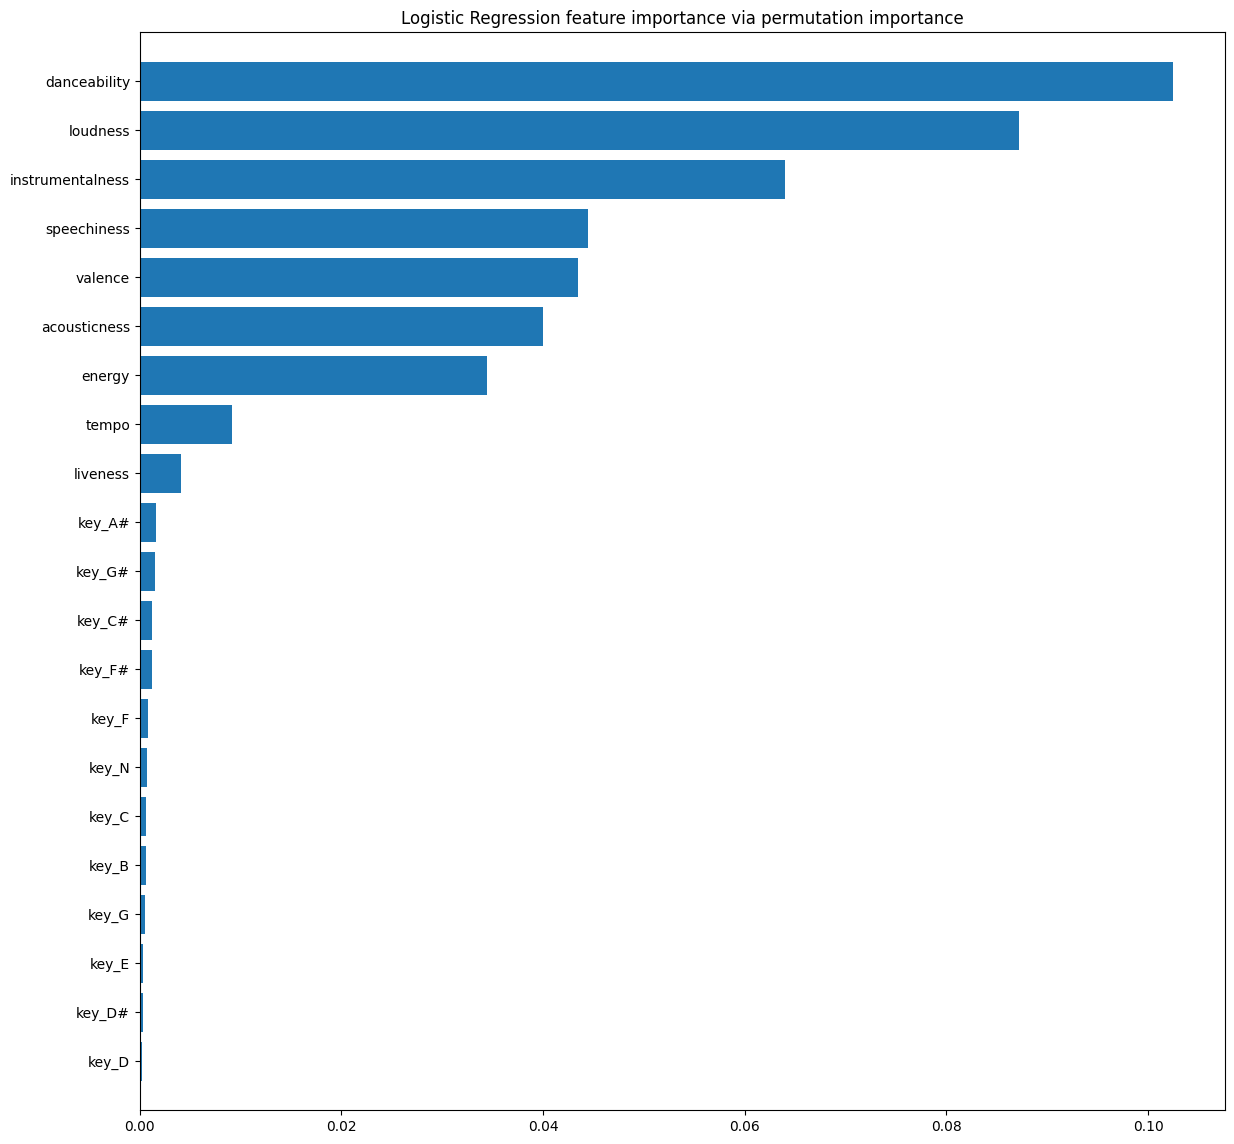

In [68]:
import numpy as np
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [features_valid.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(features_valid.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(features_valid.shape[1]), perm_features)
plt.ylim([features_valid.shape[1], -1])
plt.show()

In [69]:
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = features_train_up[perm_features[:8]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,target_train_up)
predictProba(lr, X_train_perm)
predictProba(lr, X_train_perm, dev=True)

              precision    recall  f1-score   support

 Alternative      0.233     0.206     0.219      4184
       Anime      0.259     0.181     0.213      4184
       Blues      0.335     0.302     0.318      4184
   Classical      0.749     0.825     0.785      4184
     Country      0.309     0.560     0.398      4184
  Electronic      0.506     0.475     0.490      4184
     Hip-Hop      0.410     0.494     0.448      4184
        Jazz      0.412     0.333     0.368      4184
         Rap      0.333     0.270     0.299      4184
        Rock      0.223     0.189     0.205      4184

    accuracy                          0.383     41840
   macro avg      0.377     0.383     0.374     41840
weighted avg      0.377     0.383     0.374     41840

              precision    recall  f1-score   support

 Alternative      0.000     0.000     0.000      1041
       Anime      0.000     0.000     0.000      1030
       Blues      0.000     0.000     0.000      1046
   Classical      0.877 

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

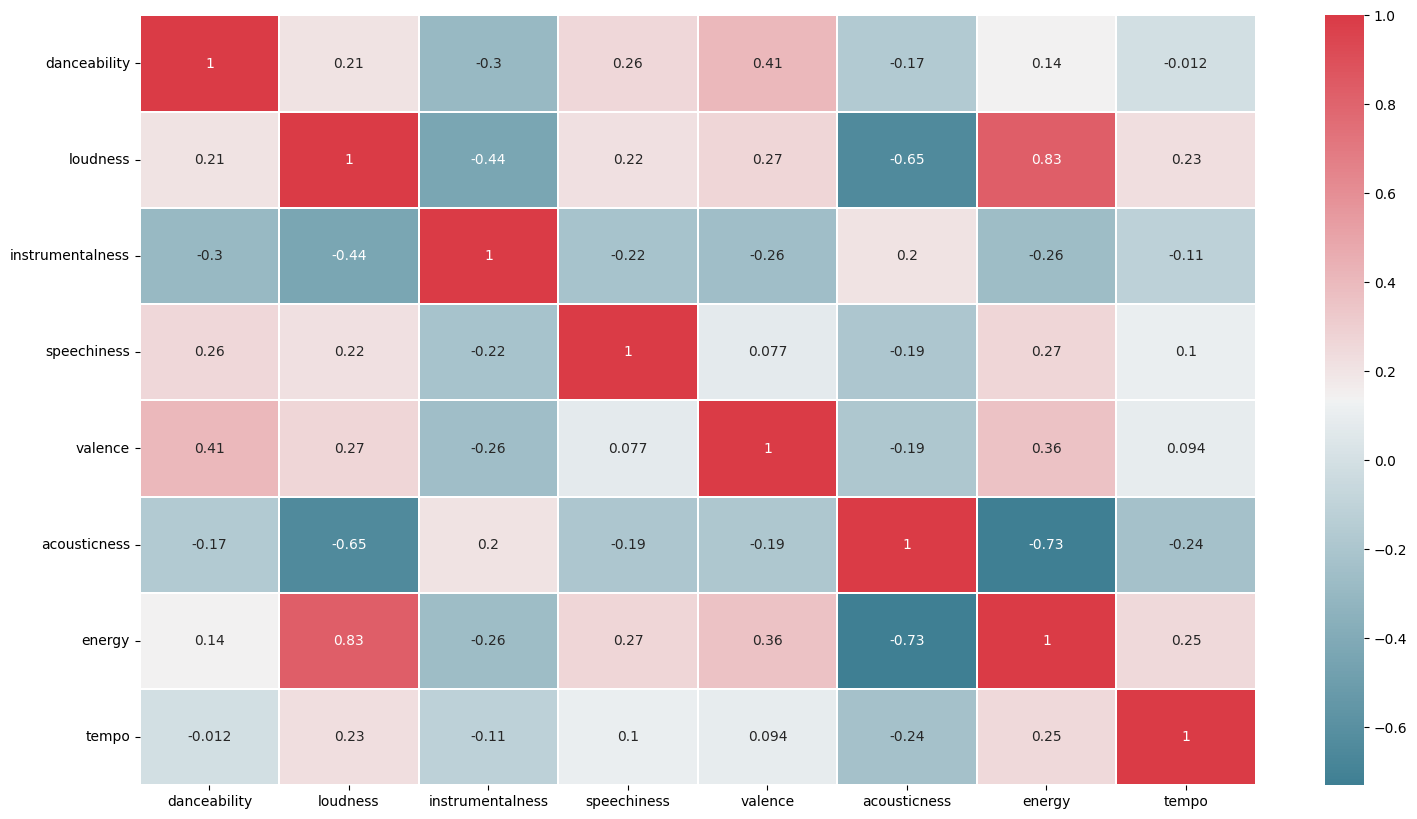

In [70]:
# plot correlation among top 30 selected featuers
plt.figure(figsize = (18, 10))
sb.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sb.diverging_palette(220, 10, as_cmap=True))
plt.show()

In [241]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfc.fit(features_set, target_train_up)
predictProba(rfc, features_set)
predictProba(rfc, features_set, True)

              precision    recall  f1-score   support

 Alternative      0.914     0.914     0.914      4184
       Anime      0.998     0.997     0.997      4184
       Blues      0.974     0.977     0.975      4184
   Classical      0.995     0.997     0.996      4184
     Country      0.964     0.969     0.967      4184
  Electronic      0.985     0.988     0.987      4184
     Hip-Hop      0.871     0.874     0.872      4184
        Jazz      0.980     0.976     0.978      4184
         Rap      0.862     0.865     0.864      4184
        Rock      0.916     0.904     0.910      4184

    accuracy                          0.946     41840
   macro avg      0.946     0.946     0.946     41840
weighted avg      0.946     0.946     0.946     41840

              precision    recall  f1-score   support

 Alternative      0.000     0.000     0.000      1041
       Anime      0.350     0.007     0.013      1030
       Blues      0.130     0.598     0.214      1046
   Classical      0.000 

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [242]:
import sklearn.ensemble as ske
abc = ske.AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE)
abc.fit(features_set, target_train_up)
predictProba(abc, features_set, True)

              precision    recall  f1-score   support

 Alternative      0.000     0.000     0.000      1041
       Anime      0.000     0.000     0.000      1030
       Blues      0.000     0.000     0.000      1046
   Classical      0.000     0.000     0.000      1021
     Country      0.000     0.000     0.000      1035
  Electronic      0.117     0.947     0.209      1040
     Hip-Hop      0.000     0.000     0.000      1017
        Jazz      0.157     0.295     0.205      1016
         Rap      0.000     0.000     0.000      1044
        Rock      0.000     0.000     0.000      1038

    accuracy                          0.124     10328
   macro avg      0.027     0.124     0.041     10328
weighted avg      0.027     0.124     0.041     10328



/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [243]:
cbc = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(features_set, target_train_up)
predictProba(cbc, features_set)
predictProba(cbc, features_set, True)

              precision    recall  f1-score   support

 Alternative      0.536     0.435     0.480      4184
       Anime      0.639     0.564     0.599      4184
       Blues      0.570     0.584     0.577      4184
   Classical      0.839     0.895     0.866      4184
     Country      0.459     0.624     0.529      4184
  Electronic      0.636     0.665     0.650      4184
     Hip-Hop      0.575     0.613     0.594      4184
        Jazz      0.515     0.625     0.565      4184
         Rap      0.587     0.511     0.547      4184
        Rock      0.560     0.369     0.444      4184

    accuracy                          0.589     41840
   macro avg      0.592     0.589     0.585     41840
weighted avg      0.592     0.589     0.585     41840

              precision    recall  f1-score   support

 Alternative      0.000     0.000     0.000      1041
       Anime      0.113     0.063     0.081      1030
       Blues      0.000     0.000     0.000      1046
   Classical      0.000 

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [244]:
y_pred_X = cbc.predict(features_test[features_set.columns])
print(skm.classification_report(target_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(target_test, y_pred_X)*100)

              precision    recall  f1-score   support

 Alternative      0.000     0.000     0.000       502
       Anime      0.110     0.072     0.087       526
       Blues      0.000     0.000     0.000       503
   Classical      0.000     0.000     0.000       504
     Country      0.000     0.000     0.000       532
  Electronic      0.106     0.890     0.189       529
     Hip-Hop      0.000     0.000     0.000       517
        Jazz      0.102     0.060     0.076       498
         Rap      0.000     0.000     0.000       504
        Rock      0.000     0.000     0.000       484

    accuracy                          0.106      5099
   macro avg      0.032     0.102     0.035      5099
weighted avg      0.032     0.106     0.036      5099

CatBoost Test Accuracy - 10.57070013728182


/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# Baseline

In [245]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats
import random
random.seed(10)
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
kmeans.fit(features_set)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='auto', max_iter=600, n_clusters=4)

In [246]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier(n_neighbors=8)

In [247]:

knn_model = knn.fit(features_set, target_train_up)

In [248]:
features_test = features_test.drop(['instance_id'], axis=1)

In [250]:
features_set.isna().sum()

acousticness    0
danceability    0
energy          0
liveness        0
loudness        0
tempo           0
valence         0
dtype: int64

In [251]:
knn_pred = knn.predict(features_set_v)

In [132]:
print("Based on our current metrics, the accuracy of genre prediction is:",metrics.accuracy_score(target_test, knn_pred))

Based on our current metrics, the accuracy of genre prediction is: 0.10237301431653266


In [258]:
cat_features = list(range(0, features_set.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6]


In [496]:
cat_features = list(range(0, features_train.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [259]:
print('Labels: {}'.format(set(target)))

Labels: {'Alternative', 'Electronic', 'Country', 'Classical', 'Hip-Hop', 'Blues', 'Rap', 'Rock', 'Jazz', 'Anime'}


In [260]:
features_train_up = features_set.astype('str')

In [583]:
X_train_rfe = X_train_rfe.astype('str')

In [584]:
pool2 = Pool(data=X_train_rfe, label=target_train, cat_features=cat_features)

In [261]:
pool1 = Pool(data=features_train_up, label=target_train_up, cat_features=cat_features)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(features, target, train_size=0.8, random_state=RANDOM_STATE)

In [500]:
from catboost import cv

params = {}
params['loss_function'] = 'MultiClass'
params['iterations'] = 5000
params['depth'] = 10
params['custom_loss'] = ['Accuracy','F1']
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.2
params['early_stopping_rounds'] = 200

cv_data = cv(
    params = params,
    pool = Pool(features_train.astype('str'), label=target_train, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=RANDOM_STATE,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.454688461
bestIteration = 133

Training on fold [1/5]

bestTest = 1.456102234
bestIteration = 368

Training on fold [2/5]

bestTest = 1.461877463
bestIteration = 132

Training on fold [3/5]

bestTest = 1.476420412
bestIteration = 141

Training on fold [4/5]

bestTest = 1.461068985
bestIteration = 178



In [501]:
cv_data

,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,2.148478,0.015721,2.152519,0.010981,0.290694,0.011957,0.302992,0.011284,NaN,NaN,NaN,NaN
1,1,2.049025,0.012221,2.055572,0.006138,0.313800,0.007584,0.332678,0.006796,NaN,NaN,NaN,NaN
2,2,1.983595,0.012373,1.985191,0.002971,0.322012,0.006738,0.347974,0.004205,NaN,NaN,NaN,NaN
3,3,1.932281,0.012452,1.929114,0.004888,0.327316,0.008450,0.360104,0.005545,NaN,NaN,NaN,NaN
4,4,1.892842,0.014600,1.884348,0.006259,0.334412,0.010061,0.368806,0.006964,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,564,1.471175,0.010234,0.416771,0.091515,0.456228,0.006923,0.981440,0.010771,NaN,NaN,NaN,NaN
565,565,1.471201,0.010219,0.416645,0.091787,0.456107,0.006816,0.981434,0.010759,NaN,NaN,NaN,NaN
566,566,1.471197,0.010222,0.416497,0.092109,0.456011,0.006737,0.981434,0.010759,NaN,NaN,NaN,NaN
567,567,1.471222,0.010208,0.416332,0.092466,0.456107,0.006816,0.981446,0.010784,NaN,NaN,NaN,NaN


In [503]:
best_value = np.min(cv_data['test-MultiClass-mean'])
best_iter = np.argmin(cv_data['test-MultiClass-mean'])

print('Best validation MC score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-MultiClass-std'][best_iter],
    best_iter)
)

Best validation MC score, not stratified: 1.4635±0.0079 on step 142


In [504]:
mod = cv_data.return_model

AttributeError: 'DataFrame' object has no attribute 'return_model'

# Pipeline

In [505]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cat_features = list(range(0, features_train_up.shape[1]))
cat_transformer = Pipeline(steps=[('imputer', IterativeImputer(random_state=RANDOM_STATE)),
                                  ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('num', cat_transformer, cat_features)
])

In [526]:
features_test

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,12,0.3030,-7.136,0,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,10,0.0849,-5.175,1,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,11,0.1090,-4.399,0,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,12,0.1220,-4.604,1,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,3,0.0374,-8.833,1,0.2020,73.830,4-Apr,0.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,50532,What We Gonna Do About It,0.108000,0.558,163049.0,0.767,0.00000,5,0.0954,-4.561,0,0.0491,158.019,4-Apr,0.715
5095,26255,Marilyn (feat. Dominique Le Jeune),0.131000,0.435,196216.0,0.641,0.00000,12,0.2730,-7.274,1,0.1040,115.534,3-Apr,0.156
5096,67924,Bipolar,0.152000,0.756,243373.0,0.787,0.00000,3,0.2050,-7.423,1,0.2400,123.405,4-Apr,0.459
5097,79778,Dead - NGHTMRE Remix,0.001450,0.489,185600.0,0.974,0.63800,7,0.1230,-2.857,0,0.0381,150.036,4-Apr,0.665


In [537]:
# ('preprocessor', preprocessor),
model = CatBoostClassifier(loss_function='MultiClass',
                                      iterations=300,
                                      depth=10,
                                      learning_rate=0.2,
                                      random_state=RANDOM_STATE,
                                      ).fit(features_train, 
                                        target_train,
                                        eval_set=(features_test.drop(['instance_id','track_name', 'obtained_date'], axis=1), target_test))

CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/loss_description.cpp:18: auto loss is not supported

In [529]:
model.score(features_train, target_train)

0.3971998837321965

In [683]:
target_pred = model.predict(features_test.drop(['track_name', 'obtained_date'], axis=1))

pred = pd.DataFrame({'Actual': submit_test['music_genre'], 'Predicted':target_pred.ravel()})
pred

,Actual,Predicted
0,Hip-Hop,Alternative
1,Alternative,Alternative
2,Rap,Rap
3,Anime,Country
4,Anime,Jazz
...,...,...
5094,Alternative,Country
5095,Blues,Hip-Hop
5096,Electronic,Hip-Hop
5097,Country,Electronic


In [684]:
import collections

collections.Counter(submit_test['music_genre'])

Counter({'Country': 532,
         'Electronic': 529,
         'Anime': 526,
         'Hip-Hop': 517,
         'Rap': 504,
         'Classical': 504,
         'Blues': 503,
         'Alternative': 502,
         'Jazz': 498,
         'Rock': 484})

In [685]:
collections.Counter(target_pred.ravel())

Counter({'Blues': 647,
         'Country': 587,
         'Electronic': 580,
         'Rock': 554,
         'Rap': 530,
         'Alternative': 521,
         'Hip-Hop': 439,
         'Anime': 423,
         'Classical': 412,
         'Jazz': 406})

In [686]:
from sklearn.metrics import classification_report

print('Accurace:', accuracy_score(submit_test['music_genre'], target_pred))



Accurace: 0.09590115708962542


In [691]:
print(classification_report(submit_test['music_genre'], target_pred))

              precision    recall  f1-score   support

 Alternative       0.10      0.10      0.10       502
       Anime       0.09      0.07      0.08       526
       Blues       0.09      0.12      0.10       503
   Classical       0.12      0.10      0.11       504
     Country       0.09      0.10      0.09       532
  Electronic       0.09      0.10      0.10       529
     Hip-Hop       0.10      0.09      0.10       517
        Jazz       0.09      0.07      0.08       498
         Rap       0.09      0.10      0.10       504
        Rock       0.10      0.11      0.10       484

    accuracy                           0.10      5099
   macro avg       0.10      0.10      0.10      5099
weighted avg       0.10      0.10      0.10      5099



In [692]:
predictions = model.predict(features_test.drop(['track_name', 'obtained_date'], axis=1))
predictions

array([['Alternative'],
       ['Alternative'],
       ['Rap'],
       ...,
       ['Hip-Hop'],
       ['Electronic'],
       ['Jazz']], dtype=object)

In [693]:
target_pred

array([['Alternative'],
       ['Alternative'],
       ['Rap'],
       ...,
       ['Hip-Hop'],
       ['Electronic'],
       ['Jazz']], dtype=object)

In [694]:
submission = pd.DataFrame({
    'instance_id': submit_test['instance_id'],
    'music_genre': target_pred.ravel()
})
submission.to_csv('submission.csv', index=False)
submission±

,instance_id,music_genre
0,48564,Alternative
1,72394,Alternative
2,88081,Rap
3,78331,Country
4,72636,Jazz
...,...,...
5094,50532,Country
5095,26255,Hip-Hop
5096,67924,Hip-Hop
5097,79778,Electronic


https://www.kaggle.com/code/shubhamlipare/random-forest-with-hyperparameter-tuning

https://www.kaggle.com/code/zjohnson87/music-features-analysis-genre-classification